# **General Prep**

In [50]:
#pip install pingouin

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import mixedlm, ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import warnings
import os
from scipy.stats import zscore, levene, ks_2samp, kruskal


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# Set a modern style
plt.style.use('seaborn-v0_8-pastel')

In [52]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

In [53]:
os.chdir('C:/Users/Ryo/OneDrive/Desktop/Master Thesis/master_thesis/study3')

# **data preparation**

## prep for the response df

In [54]:
file_loc = 'raw/Study3 - final_July_18_2024_02_35_final.xlsx'
df = pd.read_excel(file_loc)
df

ResponseId  Ads_OP_1_Reversed  Ads_OP_2_Reversed  \
0   5db4f0b63e33f2000dd54016                 22                 19   
1   66294a585f1cf3fdaeb80120                 28                 50   
2   665a52573b9527ce0011158b                 10                 10   
3   651ebcca48c60acc82f1f2bd                 60                 50   
4   6634fb892af2e227ab65f004                 80                 50   
..                       ...                ...                ...   
87  64d52f62a1f1a7371760fe4f                 82                 64   
88  66622736b3fcb6b8f3c04fdd                 88                 86   
89  6660680acd027329cecdf2b8                 37                 33   
90  5d215a1bbf7f840019701939                 53                 52   
91  663294f21bab6d7c3f7bf27b                 26                 46   

    Ads_OP_3_Reversed  Ads_OP_4_Reversed  Ads_OP_5_Reversed  \
0                  14                 16                 17   
1                  47                 72                 50   
2                  10                 10                 10   
3                  63                 90                 90   
4                  90                 85                 90   
..                ...                ...                ...   
87                 86                 72                 79   
88                 92                 83                 86   
89                 35                 49                 47   
90                 70                 62                 75   
91                 29                 42                 56   

    Ads_OP_6_Reversed  Ads_CO_1_Normal  Ads_CO_2_Normal  Ads_CO_3_Normal  \
0                  15               21               22               18   
1                  41               34               50               50   
2                  10                0                0                0   
3                  89               31               50               34   
4                  85               80               50               75   
..                ...              ...              ...              ...   
87                 90               40               44               24   
88                 85               28               41               11   
89                 46               61               56               67   
90                 82               35               49               28   
91                 34               40               40               18   

    Ads_CO_4_Normal  Ads_CO_5_Normal  Ads_CO_6_Normal  Ads_EX_1_Reversed  \
0                18               18               15                 24   
1                59               46               21                 46   
2                 0                0                0                 10   
3                50               39               37                 62   
4                50               75               87                 95   
..              ...              ...              ...                ...   
87               37               31               15                 39   
88               28               28               16                 81   
89               53               74               86                  0   
90               40               31               33                 69   
91               37               37               46                  6   

    Ads_EX_2_Reversed  Ads_EX_3_Reversed  Ads_EX_4_Reversed  \
0                  25                 23                 22   
1                  50                 58                 62   
2                  10                 10                 10   
3                  50                 65                 80   
4                  50                 95                 50   
..                ...                ...                ...   
87                 31                 21                 21   
88                 78                 87                 81   
89                  0      

In [55]:
print(f"shape {df.shape}")

shape (92, 29)


In [56]:
file_loc = 'raw/20240721_prolific_export.csv'
target_respondants = pd.read_csv(file_loc)
target_respondants = target_respondants[target_respondants['Status'] == 'APPROVED']['Participant id'].unique().tolist()
len(target_respondants)

90

In [57]:
study3_respondants = df['ResponseId'].tolist()
print(f"original respondse counts: {len(study3_respondants)}")

# filter df to target participants
# Count non-null values for each row
df['non_null_count'] = df.notna().sum(axis=1)

# Sort by 'ResponseId' and 'non_null_count' (descending), then drop duplicates
df = df.sort_values(['ResponseId', 'non_null_count'], ascending=[True, False]).drop_duplicates('ResponseId')

# Remove the temporary 'non_null_count' column
df = df.drop('non_null_count', axis=1)

# Filter to keep only target respondents
s3_response_df = df[df['ResponseId'].isin(target_respondants)]
print(f"final respondse counts: {len(s3_response_df['ResponseId'])}")


original respondse counts: 92
final respondse counts: 90


In [58]:
# Reverse scores for columns ending with '_Reversed'
reversed_columns = [col for col in s3_response_df.columns if col.endswith('_Reversed')]
for col in reversed_columns:
    s3_response_df[col] = 100 - s3_response_df[col]

# Remove '_Normal' or '_Reversed' from all column names
s3_response_df.columns = s3_response_df.columns.str.replace('_Normal', '').str.replace('_Reversed', '')

# Display the modified DataFrame
s3_response_df

ResponseId  Ads_OP_1  Ads_OP_2  Ads_OP_3  Ads_OP_4  \
12  577f70d1454e5400015f1845        72        59        70        34   
81  5a2adf6a8e00a000019864fb        72        55        64        67   
33  5aa806e7777df200016088c5        20         9         0         0   
63  5afe053059ae1e00017e6a3c        78        19        17        16   
10  5b757a03976ecb0001b1168f         8        19         0         0   
..                       ...       ...       ...       ...       ...   
82  66645cff5b7cb46819ac4d8a        72        71        72        75   
11  6664b0106c4f8ba1febc5a1a        17        30        21         8   
84  6665899df8740e0a2b6798fa        16         8        11         6   
19  666667f3e900925d27fe40d7        11        11         3         5   
26  6669a1aedfa639b507eccff6        79        66        77        85   

    Ads_OP_5  Ads_OP_6  Ads_CO_1  Ads_CO_2  Ads_CO_3  Ads_CO_4  Ads_CO_5  \
12        88        83        88        85        91        87        95   
81        58        70        27        39        35        35        22   
33         0         0        16         0         6         0        11   
63        17        19         0        20        18        62         9   
10         0         0        64        73        73        65        68   
..       ...       ...       ...       ...       ...       ...       ...   
82        78        75        71        74        77        76        74   
11        14         9        78        68        75         0        73   
84        10        14        89        93        86        88        91   
19         5         7        91        75       100        81        84   
26        67        76        26        21        16        36        38   

    Ads_CO_6  Ads_EX_1  Ads_EX_2  Ads_EX_3  Ads_EX_4  Ads_EX_5  Ads_EX_6  \
12        93         7        29        36         5        20        10   
81        29        74        70        82        77        75        80   
33         0        16         0         2        10         4         0   
63        10        47        46        47        27        46        47   
10        70        27        39        14         8        17         7   
..       ...       ...       ...       ...       ...       ...       ...   
82        72        77        82        80        81        85        86   
11        91        23        30         4        38        22        22   
84        88        15         5        12        10        10         8   
19        87        94        94        87        90       100        95   
26        23        84        76        78        88        85        66   

    Ads_AG_1  Ads_AG_2  Ads_AG_3  Ads_AG_4  Ads_AG_5  Ads_AG_6  Desc_OP_1  \
12        82        89        91        88        91        91         91   
81        80        76        76        66        77        67         72   
33        62        69        54        38        48        67         84   
63        44        44        47        47        47        47         83   
10        71        84        77        68        92        93         45   
..       ...       ...       ...       ...       ...       ...        ...   
82        59        61        45        43        44        45         86   
11        36        73        81         0        91        41         74   
84        94        90        87        90        92        88         91   
19        79        88        92        90        88       100        100   
26        60        62        56        69        61        66         24   

    Desc_CO_1  Desc_EX_1  Desc_AG_1  
12         85         88          6  
81         25         26         71  
33         74         23         59  
63         72         70         64  
10         27         81         42  
..        ...        ...        ...  
82         73         80         67  
11         14         69         30  
84         75         88         79  
19         98         

## prep for socioecnomic and big5 scores

In [59]:
big5_file_loc = 'raw/big5_scores.csv'
big5_df = pd.read_csv(big5_file_loc)
big5_df.tail(5)

ResponseId  Extraversion  Agreeableness  Conscientiousness  \
99   60a062ed4c4334abbbf32323      3.333333       3.000000           3.166667   
100  5f3ac1732efa0a74f975b1a8      3.500000       4.833333           4.333333   
101  6601b51675d287d6a62f11c4      3.666667       4.833333           4.333333   
102  656f2e99bd2939f9b3f9d090      3.833333       4.000000           4.666667   
103  6658822c0f5b1367a1585ee1      4.500000       4.666667           5.000000   

     Neuroticism  Open_Mindedness  
99      3.666667         4.166667  
100     1.000000         3.000000  
101     1.166667         4.666667  
102     1.666667         4.000000  
103     1.333333         3.166667

In [60]:
socioecono_file_loc = 'raw/socioecono_scores.csv'
socioecono_df = pd.read_csv(socioecono_file_loc)
socioecono_df.tail(5)

ResponseId  gender  age  education  race  employment  \
99   60a062ed4c4334abbbf32323       2   27          4     2           1   
100  5f3ac1732efa0a74f975b1a8       2   30          2     1           6   
101  6601b51675d287d6a62f11c4       2   55          5     2           9   
102  656f2e99bd2939f9b3f9d090       1   43          5     2           7   
103  6658822c0f5b1367a1585ee1       2   43          5     2           7   

     income  
99        1  
100       5  
101      11  
102      12  
103       8

In [61]:
# filter socioecono_df and big5_df to study3 participants
socioecono_df = socioecono_df[socioecono_df['ResponseId'].isin(target_respondants)]
big5_df = big5_df[big5_df['ResponseId'].isin(target_respondants)]
print(f"row # for socioecono_df : {len(socioecono_df['ResponseId'])}, row # for big5_df : {len(big5_df['ResponseId'])}")

row # for socioecono_df : 90, row # for big5_df : 90


## demographic analysis

In [62]:
print(f"mean age {socioecono_df['age'].mean()} with sd {socioecono_df['age'].std()}, female % {socioecono_df[socioecono_df['gender']==1]['gender'].sum()/socioecono_df.shape[0]}")

mean age 40.86666666666667 with sd 11.74466170869495, female % 0.4777777777777778


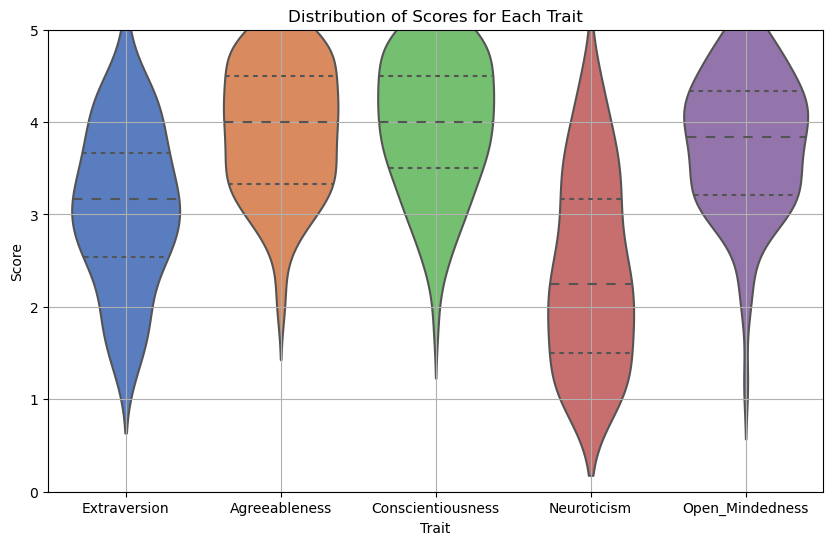

In [63]:
# Melt the DataFrame
big5_df_num = big5_df.iloc[:,1:]
big5_df_melted = big5_df_num.melt(var_name='Trait', value_name='Score')

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Trait', y='Score', data=big5_df_melted, inner='quartile', palette='muted')
plt.title('Distribution of Scores for Each Trait')
plt.ylim(0, 5)
plt.xlabel('Trait')
plt.ylabel('Score')
plt.grid(True)

# Show the plot
plt.show()

## generating distance for a single trait and blended traits

In [64]:
"""
# Extract rows where all Big 5 scores are greater than 3
big5_df_high_scorers = big5_df[
                               (big5_df['Extraversion'] > 3) & 
                               (big5_df['Agreeableness'] > 3) & 
                               (big5_df['Conscientiousness'] > 3) & 
                               (big5_df['Open_Mindedness'] > 3)
]

# Display the result
print(f"Number of participants with targeted Big 5 scores > 3: {len(big5_df_high_scorers)}")
#print(big5_df_high_scorers)
"""

'\n# Extract rows where all Big 5 scores are greater than 3\nbig5_df_high_scorers = big5_df[\n                               (big5_df[\'Extraversion\'] > 3) & \n                               (big5_df[\'Agreeableness\'] > 3) & \n                               (big5_df[\'Conscientiousness\'] > 3) & \n                               (big5_df[\'Open_Mindedness\'] > 3)\n]\n\n# Display the result\nprint(f"Number of participants with targeted Big 5 scores > 3: {len(big5_df_high_scorers)}")\n#print(big5_df_high_scorers)\n'

In [65]:
"""
# Extract rows where all Big 5 scores are greater than 3
big5_df_ex_high_scorers = big5_df[big5_df['Extraversion'] > 3]['ResponseId'].tolist()
big5_df_ag_high_scorers = big5_df[big5_df['Agreeableness'] > 3]['ResponseId'].tolist()
big5_df_co_high_scorers = big5_df[big5_df['Conscientiousness'] > 3]['ResponseId'].tolist()
big5_df_op_high_scorers = big5_df[big5_df['Open_Mindedness'] > 3]['ResponseId'].tolist()

# Display the result
print(f"Number of participants with op > 3: {len(big5_df_op_high_scorers)}")
print(f"Number of participants with co > 3: {len(big5_df_co_high_scorers)}")
print(f"Number of participants with ex > 3: {len(big5_df_ex_high_scorers)}")
print(f"Number of participants with ag > 3: {len(big5_df_ag_high_scorers)}")

big5_dfs_dict = {}
big5_dfs_dict['op'] = big5_df[big5_df['ResponseId'].isin(big5_df_op_high_scorers)]
big5_dfs_dict['co'] = big5_df[big5_df['ResponseId'].isin(big5_df_co_high_scorers)]
big5_dfs_dict['ex'] = big5_df[big5_df['ResponseId'].isin(big5_df_ex_high_scorers)]
big5_dfs_dict['ag'] = big5_df[big5_df['ResponseId'].isin(big5_df_ag_high_scorers)]
"""

'\n# Extract rows where all Big 5 scores are greater than 3\nbig5_df_ex_high_scorers = big5_df[big5_df[\'Extraversion\'] > 3][\'ResponseId\'].tolist()\nbig5_df_ag_high_scorers = big5_df[big5_df[\'Agreeableness\'] > 3][\'ResponseId\'].tolist()\nbig5_df_co_high_scorers = big5_df[big5_df[\'Conscientiousness\'] > 3][\'ResponseId\'].tolist()\nbig5_df_op_high_scorers = big5_df[big5_df[\'Open_Mindedness\'] > 3][\'ResponseId\'].tolist()\n\n# Display the result\nprint(f"Number of participants with op > 3: {len(big5_df_op_high_scorers)}")\nprint(f"Number of participants with co > 3: {len(big5_df_co_high_scorers)}")\nprint(f"Number of participants with ex > 3: {len(big5_df_ex_high_scorers)}")\nprint(f"Number of participants with ag > 3: {len(big5_df_ag_high_scorers)}")\n\nbig5_dfs_dict = {}\nbig5_dfs_dict[\'op\'] = big5_df[big5_df[\'ResponseId\'].isin(big5_df_op_high_scorers)]\nbig5_dfs_dict[\'co\'] = big5_df[big5_df[\'ResponseId\'].isin(big5_df_co_high_scorers)]\nbig5_dfs_dict[\'ex\'] = big5_df[

In [66]:
"""
socioecono_df_high_op = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_op_high_scorers)]
socioecono_df_high_co = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_co_high_scorers)]
socioecono_df_high_ex = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_ex_high_scorers)]
socioecono_df_high_ag = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_ag_high_scorers)]


print(f"OP: mean age {socioecono_df_high_op['age'].mean()} with sd {socioecono_df_high_op['age'].std()}, female % {socioecono_df_high_op[socioecono_df_high_op['gender']==1]['gender'].sum()/socioecono_df_high_op.shape[0]}")
print(f"CO: mean age {socioecono_df_high_co['age'].mean()} with sd {socioecono_df_high_co['age'].std()}, female % {socioecono_df_high_co[socioecono_df_high_co['gender']==1]['gender'].sum()/socioecono_df_high_co.shape[0]}")
print(f"EX: mean age {socioecono_df_high_ex['age'].mean()} with sd {socioecono_df_high_ex['age'].std()}, female % {socioecono_df_high_ex[socioecono_df_high_ex['gender']==1]['gender'].sum()/socioecono_df_high_ex.shape[0]}")
print(f"AG: mean age {socioecono_df_high_ag['age'].mean()} with sd {socioecono_df_high_ag['age'].std()}, female % {socioecono_df_high_ag[socioecono_df_high_ag['gender']==1]['gender'].sum()/socioecono_df_high_ag.shape[0]}")

socioecono_dfs_dict = {}
socioecono_dfs_dict['op'] = socioecono_df_high_op
socioecono_dfs_dict['co'] = socioecono_df_high_co
socioecono_dfs_dict['ex'] = socioecono_df_high_ex
socioecono_dfs_dict['ag'] = socioecono_df_high_ag
"""

'\nsocioecono_df_high_op = socioecono_df[socioecono_df[\'ResponseId\'].isin(big5_df_op_high_scorers)]\nsocioecono_df_high_co = socioecono_df[socioecono_df[\'ResponseId\'].isin(big5_df_co_high_scorers)]\nsocioecono_df_high_ex = socioecono_df[socioecono_df[\'ResponseId\'].isin(big5_df_ex_high_scorers)]\nsocioecono_df_high_ag = socioecono_df[socioecono_df[\'ResponseId\'].isin(big5_df_ag_high_scorers)]\n\n\nprint(f"OP: mean age {socioecono_df_high_op[\'age\'].mean()} with sd {socioecono_df_high_op[\'age\'].std()}, female % {socioecono_df_high_op[socioecono_df_high_op[\'gender\']==1][\'gender\'].sum()/socioecono_df_high_op.shape[0]}")\nprint(f"CO: mean age {socioecono_df_high_co[\'age\'].mean()} with sd {socioecono_df_high_co[\'age\'].std()}, female % {socioecono_df_high_co[socioecono_df_high_co[\'gender\']==1][\'gender\'].sum()/socioecono_df_high_co.shape[0]}")\nprint(f"EX: mean age {socioecono_df_high_ex[\'age\'].mean()} with sd {socioecono_df_high_ex[\'age\'].std()}, female % {socioecono

In [67]:
mixed_trait_scores = pd.read_csv('raw/mixed_trait_scores.csv')
mixed_trait_scores

Extraversion  Agreeableness  Conscientiousness  Open_Mindedness
0      3.166667            4.0                4.0         3.833333

In [68]:
big5_dict = {'op': 'Open_Mindedness',
             'co': 'Conscientiousness',
             'ex': 'Extraversion',
             'ag': 'Agreeableness'}


In [69]:
def calculate_distance(df, mixed_scores, trait):
    trait_full = big5_dict[trait]
    return np.abs(df[trait_full] - mixed_scores[trait_full].values[0])

def calculate_distance_from_max(df, trait):
    trait_full = big5_dict[trait]
    return 5 - df[trait_full]

def generate_big5_distance_df(big5_df, mixed_trait_scores):
    distances = pd.DataFrame(index=big5_df.index)
    
    for trait in big5_dict.keys():
        distances[f'{trait}_distance'] = calculate_distance(big5_df, mixed_trait_scores, trait)
        distances[f'{trait}_distance_from_max'] = calculate_distance_from_max(big5_df, trait)
    
    distances['total_distance'] = distances[[f'{trait}_distance' for trait in big5_dict.keys()]].sum(axis=1)
    
    distance_columns = [f'{trait}_distance' for trait in big5_dict.keys()]
    distances['average_distance'] = distances[distance_columns].mean(axis=1)
    
    return pd.concat([big5_df['ResponseId'], distances], axis=1)

def generate_big5_distance_type_df(df, mixed_trait_scores):
    distances = pd.DataFrame(index=df.index)
    
    for trait in big5_dict.keys():
        distances[f'{trait}_distance'] = calculate_distance(df, mixed_trait_scores, trait)
        distances[f'{trait}_distance_from_max'] = calculate_distance_from_max(df, trait)
    
    distances['total_distance'] = distances[[f'{trait}_distance' for trait in big5_dict.keys()]].sum(axis=1)
    
    distance_columns = [f'{trait}_distance' for trait in big5_dict.keys()]
    distances['average_distance'] = distances[distance_columns].mean(axis=1)
    
    return pd.concat([df['ResponseId'], distances], axis=1)

# Generate big5_distance_df for all respondents
big5_distance_df = generate_big5_distance_df(big5_df, mixed_trait_scores)

# Generate big5_distance_{type} for each type (20240727 ceased)
"""
big5_distance_dfs_dict = {}
for type, df in big5_dfs_dict.items():
    big5_distance_dfs_dict[type] = generate_big5_distance_type_df(df, mixed_trait_scores)
    globals()[f'big5_distance_{type}'] = big5_distance_dfs_dict[type]
"""

# Display summary statistics for the comprehensive DataFrame
print("Summary for all responses:")
print(big5_distance_df.describe())
print("\n")

# Display top 5 closest participants based on total distance for all responses
print("Top 5 closest participants for all responses based on total distance:")
print(big5_distance_df.sort_values('total_distance').head())
print("\n" + "="*50 + "\n")

Summary for all responses:
       op_distance  op_distance_from_max  co_distance  co_distance_from_max  \
count    90.000000             90.000000    90.000000             90.000000   
mean      0.587037              1.235185     0.609259              1.038889   
std       0.440766              0.733493     0.423381              0.743700   
min       0.000000              0.000000     0.000000              0.000000   
25%       0.333333              0.666667     0.333333              0.500000   
50%       0.500000              1.166667     0.500000              1.000000   
75%       0.833333              1.791667     0.833333              1.500000   
max       2.666667              3.833333     2.166667              3.166667   

       ex_distance  ex_distance_from_max  ag_distance  ag_distance_from_max  \
count    90.000000             90.000000    90.000000             90.000000   
mean      0.694444              1.920370     0.585185              1.081481   
std       0.509124      

<Axes: >

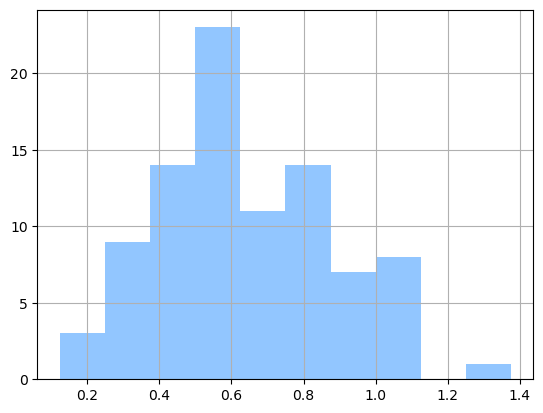

In [70]:
big5_distance_df['average_distance'].hist()

## Introduce a merged_df

All recorded by ResponseId
- **s3_response_df**   : has all of the 0 - 100 scale scores from the survey
- **big5_distance_df** : (1) distances for each trait from the benchmark scores(median) of a blended personality.  (2) distances for each trait from the max score(=5). (3) total and average distances from the benchmark scores of a blended personality
- **socioecono_df**    : socio economic scores

In [71]:
big5_distance_df.head(1)

ResponseId  op_distance  op_distance_from_max  co_distance  \
1  641357b26802e397b5627d5e     0.333333              0.833333     0.166667   

   co_distance_from_max  ex_distance  ex_distance_from_max  ag_distance  \
1              0.833333     0.666667              1.166667     0.833333   

   ag_distance_from_max  total_distance  average_distance  
1              1.833333             2.0               0.5

In [72]:
s3_response_df.head(1)

ResponseId  Ads_OP_1  Ads_OP_2  Ads_OP_3  Ads_OP_4  \
12  577f70d1454e5400015f1845        72        59        70        34   

    Ads_OP_5  Ads_OP_6  Ads_CO_1  Ads_CO_2  Ads_CO_3  Ads_CO_4  Ads_CO_5  \
12        88        83        88        85        91        87        95   

    Ads_CO_6  Ads_EX_1  Ads_EX_2  Ads_EX_3  Ads_EX_4  Ads_EX_5  Ads_EX_6  \
12        93         7        29        36         5        20        10   

    Ads_AG_1  Ads_AG_2  Ads_AG_3  Ads_AG_4  Ads_AG_5  Ads_AG_6  Desc_OP_1  \
12        82        89        91        88        91        91         91   

    Desc_CO_1  Desc_EX_1  Desc_AG_1  
12         85         88          6

In [73]:
# Merge big5_distance_df, s3_response_df, and socioecono_df on ResponseId
merged_df = pd.merge(big5_distance_df, s3_response_df, on='ResponseId', how='inner')
merged_df = pd.merge(merged_df, socioecono_df, on='ResponseId', how='inner')

# Rename columns in the merged dataframe
column_mapping = {
    'op_distance': 'OP_distance',
    'op_distance_from_max': 'OP_distance_from_max',
    'co_distance': 'CO_distance',
    'co_distance_from_max': 'CO_distance_from_max',
    'ex_distance': 'EX_distance',
    'ex_distance_from_max': 'EX_distance_from_max',
    'ag_distance': 'AG_distance',
    'ag_distance_from_max': 'AG_distance_from_max'
}

merged_df = merged_df.rename(columns=column_mapping)

# Display the column names to verify the changes
print("\nColumn names:")
print(merged_df.columns)



Column names:
Index(['ResponseId', 'OP_distance', 'OP_distance_from_max', 'CO_distance',
       'CO_distance_from_max', 'EX_distance', 'EX_distance_from_max',
       'AG_distance', 'AG_distance_from_max', 'total_distance',
       'average_distance', 'Ads_OP_1', 'Ads_OP_2', 'Ads_OP_3', 'Ads_OP_4',
       'Ads_OP_5', 'Ads_OP_6', 'Ads_CO_1', 'Ads_CO_2', 'Ads_CO_3', 'Ads_CO_4',
       'Ads_CO_5', 'Ads_CO_6', 'Ads_EX_1', 'Ads_EX_2', 'Ads_EX_3', 'Ads_EX_4',
       'Ads_EX_5', 'Ads_EX_6', 'Ads_AG_1', 'Ads_AG_2', 'Ads_AG_3', 'Ads_AG_4',
       'Ads_AG_5', 'Ads_AG_6', 'Desc_OP_1', 'Desc_CO_1', 'Desc_EX_1',
       'Desc_AG_1', 'gender', 'age', 'education', 'race', 'employment',
       'income'],
      dtype='object')


introduce normalized merged_df

array([[<Axes: title={'center': 'OP_distance'}>,
        <Axes: title={'center': 'OP_distance_from_max'}>,
        <Axes: title={'center': 'CO_distance'}>],
       [<Axes: title={'center': 'CO_distance_from_max'}>,
        <Axes: title={'center': 'EX_distance'}>,
        <Axes: title={'center': 'EX_distance_from_max'}>],
       [<Axes: title={'center': 'AG_distance'}>,
        <Axes: title={'center': 'AG_distance_from_max'}>,
        <Axes: title={'center': 'total_distance'}>],
       [<Axes: title={'center': 'average_distance'}>, <Axes: >, <Axes: >]],
      dtype=object)

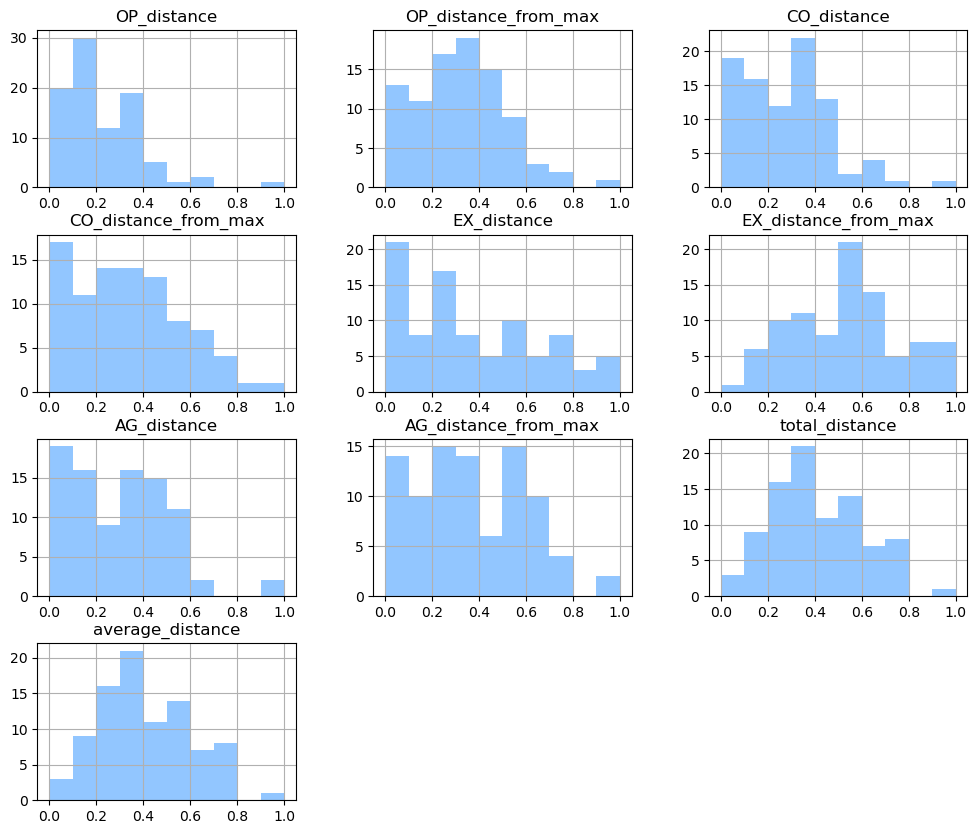

In [74]:
# Define the columns to normalize
columns_to_normalize = [
    'OP_distance', 'OP_distance_from_max', 'CO_distance', 'CO_distance_from_max',
    'EX_distance', 'EX_distance_from_max', 'AG_distance', 'AG_distance_from_max',
    'total_distance', 'average_distance'
]

# Create a new DataFrame with normalized columns
merged_df_norm = merged_df.copy()

# Normalize the specified columns
for column in columns_to_normalize:
    merged_df_norm[column] = (merged_df_norm[column] - merged_df_norm[column].min()) / (merged_df_norm[column].max() - merged_df_norm[column].min())

merged_df_norm[columns_to_normalize].hist(figsize= (12,10))


In [75]:
merged_df.head(1)

ResponseId  OP_distance  OP_distance_from_max  CO_distance  \
0  641357b26802e397b5627d5e     0.333333              0.833333     0.166667   

   CO_distance_from_max  EX_distance  EX_distance_from_max  AG_distance  \
0              0.833333     0.666667              1.166667     0.833333   

   AG_distance_from_max  total_distance  average_distance  Ads_OP_1  Ads_OP_2  \
0              1.833333             2.0               0.5        89        75   

   Ads_OP_3  Ads_OP_4  Ads_OP_5  Ads_OP_6  Ads_CO_1  Ads_CO_2  Ads_CO_3  \
0        89        84        71        75        81        66        74   

   Ads_CO_4  Ads_CO_5  Ads_CO_6  Ads_EX_1  Ads_EX_2  Ads_EX_3  Ads_EX_4  \
0        77        79        82        72        68        67        68   

   Ads_EX_5  Ads_EX_6  Ads_AG_1  Ads_AG_2  Ads_AG_3  Ads_AG_4  Ads_AG_5  \
0        76        69        71        78        70        68        85   

   Ads_AG_6  Desc_OP_1  Desc_CO_1  Desc_EX_1  Desc_AG_1  gender  age  \
0        84         63         50         53         50       1   36   

   education  race  employment  income  
0          5     1           7       7

In [76]:
merged_df_norm.head(1)

ResponseId  OP_distance  OP_distance_from_max  CO_distance  \
0  641357b26802e397b5627d5e        0.125              0.217391     0.076923   

   CO_distance_from_max  EX_distance  EX_distance_from_max  AG_distance  \
0              0.263158     0.363636              0.318182     0.416667   

   AG_distance_from_max  total_distance  average_distance  Ads_OP_1  Ads_OP_2  \
0              0.611111             0.3               0.3        89        75   

   Ads_OP_3  Ads_OP_4  Ads_OP_5  Ads_OP_6  Ads_CO_1  Ads_CO_2  Ads_CO_3  \
0        89        84        71        75        81        66        74   

   Ads_CO_4  Ads_CO_5  Ads_CO_6  Ads_EX_1  Ads_EX_2  Ads_EX_3  Ads_EX_4  \
0        77        79        82        72        68        67        68   

   Ads_EX_5  Ads_EX_6  Ads_AG_1  Ads_AG_2  Ads_AG_3  Ads_AG_4  Ads_AG_5  \
0        76        69        71        78        70        68        85   

   Ads_AG_6  Desc_OP_1  Desc_CO_1  Desc_EX_1  Desc_AG_1  gender  age  \
0        84         63         50         53         50       1   36   

   education  race  employment  income  
0          5     1           7       7

## Further data processing

In [77]:
# データの読み込み（既存のデータフレームを 'data' とします）

# 1. 相対的選好スコアの作成
traits = ['EX', 'OP', 'CO', 'AG']
for trait in traits:
    merged_df[f'Desc_{trait}_relative_1'] = merged_df[f'Desc_{trait}_1'] - 50
    merged_df_norm[f'Desc_{trait}_relative_1'] = merged_df_norm[f'Desc_{trait}_1'] - 50
    for i in range(1, 7):
        merged_df[f'Ads_{trait}_relative_{i}'] = merged_df[f'Ads_{trait}_{i}'] - 50
        merged_df_norm[f'Ads_{trait}_relative_{i}'] = merged_df_norm[f'Ads_{trait}_{i}'] - 50

In [78]:
merged_df.columns

Index(['ResponseId', 'OP_distance', 'OP_distance_from_max', 'CO_distance',
       'CO_distance_from_max', 'EX_distance', 'EX_distance_from_max',
       'AG_distance', 'AG_distance_from_max', 'total_distance',
       'average_distance', 'Ads_OP_1', 'Ads_OP_2', 'Ads_OP_3', 'Ads_OP_4',
       'Ads_OP_5', 'Ads_OP_6', 'Ads_CO_1', 'Ads_CO_2', 'Ads_CO_3', 'Ads_CO_4',
       'Ads_CO_5', 'Ads_CO_6', 'Ads_EX_1', 'Ads_EX_2', 'Ads_EX_3', 'Ads_EX_4',
       'Ads_EX_5', 'Ads_EX_6', 'Ads_AG_1', 'Ads_AG_2', 'Ads_AG_3', 'Ads_AG_4',
       'Ads_AG_5', 'Ads_AG_6', 'Desc_OP_1', 'Desc_CO_1', 'Desc_EX_1',
       'Desc_AG_1', 'gender', 'age', 'education', 'race', 'employment',
       'income', 'Desc_EX_relative_1', 'Ads_EX_relative_1',
       'Ads_EX_relative_2', 'Ads_EX_relative_3', 'Ads_EX_relative_4',
       'Ads_EX_relative_5', 'Ads_EX_relative_6', 'Desc_OP_relative_1',
       'Ads_OP_relative_1', 'Ads_OP_relative_2', 'Ads_OP_relative_3',
       'Ads_OP_relative_4', 'Ads_OP_relative_5', 'Ads_OP_relative_

## Introduce stmd_merge_df

In [79]:
# 'ResponseId'
distance_col = ['OP_distance_from_max', 
                'CO_distance_from_max', 
                'EX_distance_from_max',
                'AG_distance_from_max', 
                'average_distance']
socioecono_col = ['gender', 
                  'age', 
                  'education', 
                  'race', 
                  'employment',
                  'income']
ads_score_col = ['Ads_EX_relative_1',
                 'Ads_OP_relative_1',
                 'Ads_CO_relative_1',
                 'Ads_AG_relative_1']
desc_score_col = ['Desc_EX_relative_1',
                  'Desc_OP_relative_1',
                  'Desc_CO_relative_1',
                  'Desc_AG_relative_1']

stmd_merged_col = ['ResponseId'] + distance_col + ads_score_col + desc_score_col + socioecono_col
stmd_merged_col

['ResponseId',
 'OP_distance_from_max',
 'CO_distance_from_max',
 'EX_distance_from_max',
 'AG_distance_from_max',
 'average_distance',
 'Ads_EX_relative_1',
 'Ads_OP_relative_1',
 'Ads_CO_relative_1',
 'Ads_AG_relative_1',
 'Desc_EX_relative_1',
 'Desc_OP_relative_1',
 'Desc_CO_relative_1',
 'Desc_AG_relative_1',
 'gender',
 'age',
 'education',
 'race',
 'employment',
 'income']

In [80]:
stmd_merged_df = merged_df[stmd_merged_col]
stmd_merged_df

ResponseId  OP_distance_from_max  CO_distance_from_max  \
0   641357b26802e397b5627d5e              0.833333              0.833333   
1   66294a585f1cf3fdaeb80120              1.833333              0.333333   
2   661571d6cc16ee34676734df              0.833333              2.000000   
3   6629f95a14b6006e6a4b0aef              0.833333              1.500000   
4   66463d8b1984a328f78252d7              0.000000              2.666667   
..                       ...                   ...                   ...   
85  5d4a6459061e2a000138bad3              0.000000              0.333333   
86  62b473736986d2b27c1427d2              2.333333              1.333333   
87  5f3ac1732efa0a74f975b1a8              2.000000              0.666667   
88  6601b51675d287d6a62f11c4              0.333333              0.666667   
89  6658822c0f5b1367a1585ee1              1.833333              0.000000   

    EX_distance_from_max  AG_distance_from_max  average_distance  \
0               1.166667              1.833333          0.500000   
1               0.833333              1.833333          0.791667   
2               1.833333              1.666667          0.500000   
3               2.000000              0.666667          0.333333   
4               1.833333              1.333333          0.791667   
..                   ...                   ...               ...   
85              1.333333              0.666667          0.666667   
86              0.833333              1.500000          0.750000   
87              1.500000              0.166667          0.583333   
88              1.333333              0.166667          0.625000   
89              0.500000              0.333333          0.916667   

    Ads_EX_relative_1  Ads_OP_relative_1  Ads_CO_relative_1  \
0                  22                 39                 31   
1                   4                 22                -16   
2                  11                -21                 10   
3                 -17                -13                 14   
4                 -34                -37                 31   
..                ...                ...                ...   
85                 43                 -2                -39   
86                -17                 22                 21   
87                -21                -45                -26   
88                -32                -32                -17   
89                 40                -10                 30   

    Ads_AG_relative_1  Desc_EX_relative_1  Desc_OP_relative_1  \
0                  21                   3                  13   
1                   6                  30                  41   
2                  15                   7                 -22   
3                  14                  15                  18   
4                 -30                  15                 -36   
..                ...                 ...                 ...   
85                -36                   4                 -43   
86                 24                  34                 -29   
87                 31                 -50                  50   
88                 21                  33                  -5   
89                 10                  10                 -10   

    Desc_CO_relative_1  Desc_AG_relative_1  gender  age  education  race  \
0                    0                   0       1   36          5     1   
1                  -40                  10       2   48          5     1   
2                   -1                   7       2   41          4     1   
3                   12                 -14       2   48          2     1   
4                   44                 -41       2   32          4     4   
..                 ...                 ...     ...  ...        ...   ...   
85                 -24                  -3       1   47          4     6   
86                 -22                  18       1   34          4     1   
87                   9                 -39       2   30          2

## descriptive

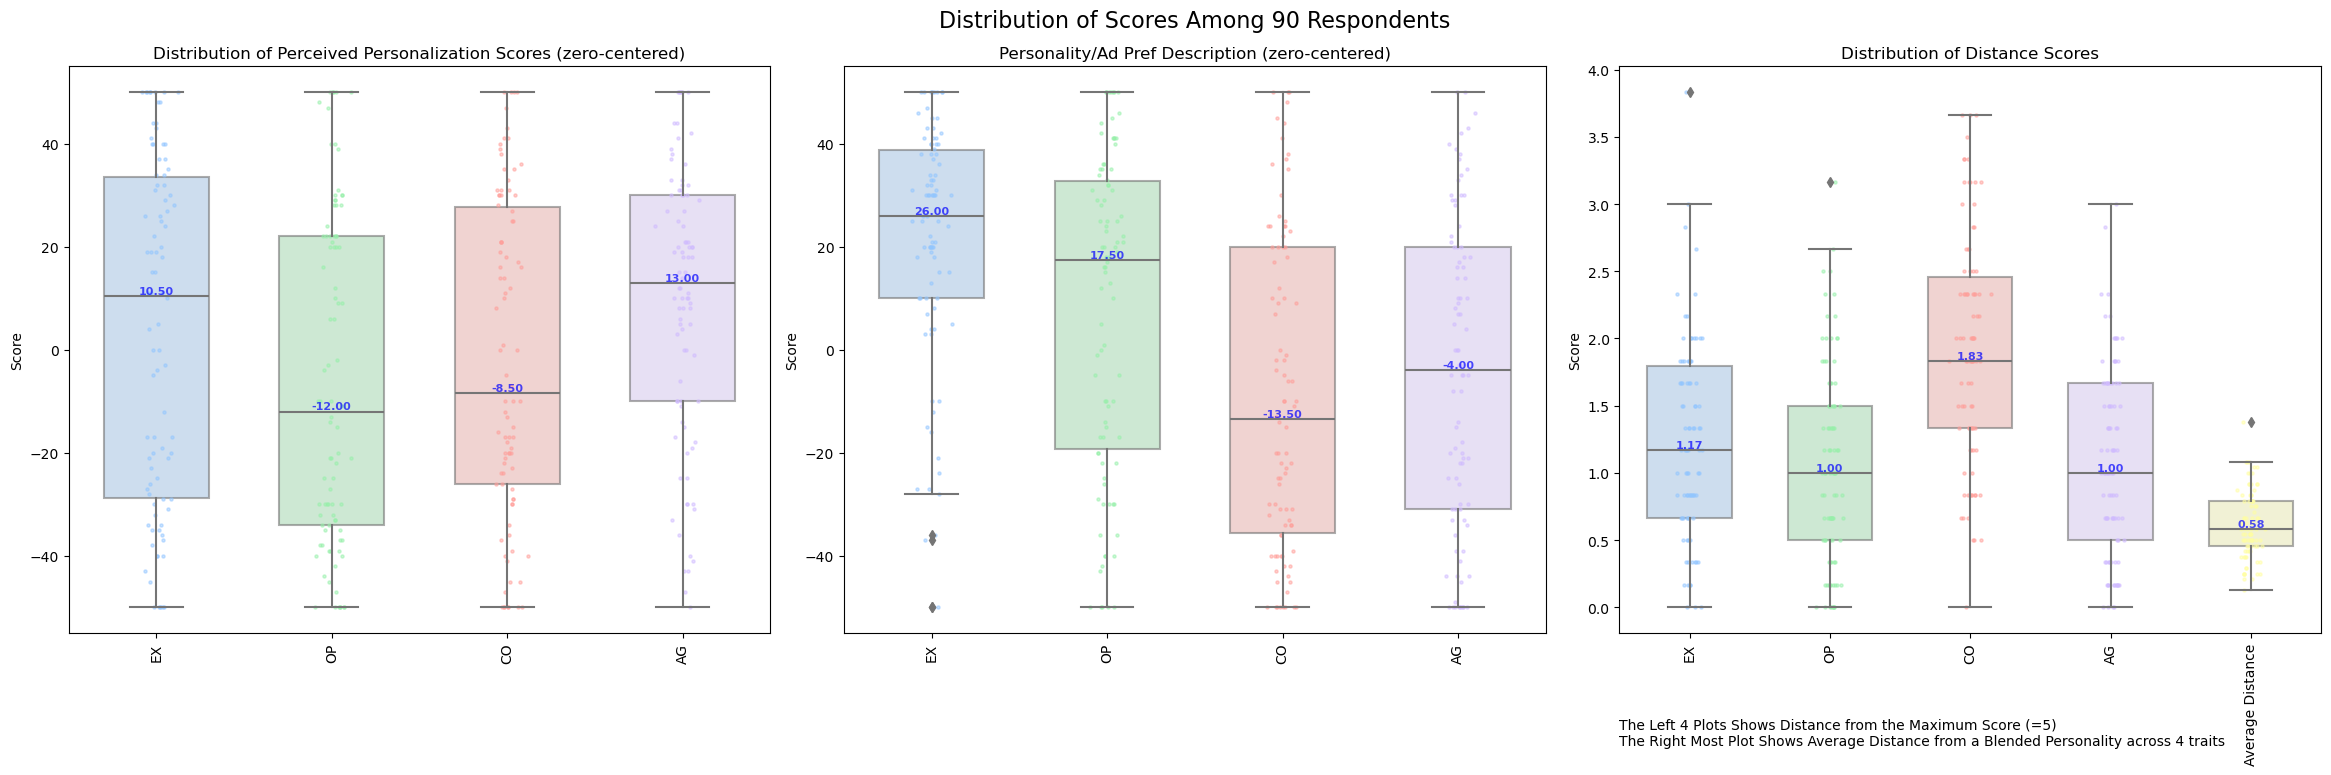

In [81]:
# Function to create boxplot with scatter and median annotation
def create_boxplot(data, columns, ax, title, xlabel_format):
    # Create boxplot
    sns.boxplot(data=data[columns], ax=ax, orient='v', width=0.6, saturation=0.5)
    
    # Set transparency for box plots
    for patch in ax.patches:
        patch.set_alpha(0.6)
    
    # Add scatter plots
    for i, col in enumerate(columns):
        x = np.random.normal(i, 0.04, size=len(data))
        ax.scatter(x, data[col], alpha=0.5, s=5)
    
    # Add median annotations
    medians = data[columns].median()
    for i, median in enumerate(medians):
        ax.text(i, median, f'{median:.2f}', 
                horizontalalignment='center', verticalalignment='bottom',
                fontweight='bold', fontsize=8, color='blue', alpha=0.7)
    
    ax.set_title(title)
    
    # Set custom x-axis labels
    ax.set_xticklabels([xlabel_format.format(trait=col.split('_')[1]) for col in columns], rotation=90)
    
    ax.set_ylabel('Score')

# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Distribution of Scores Among 90 Respondents', fontsize=16)

# Create boxplots with scatter and median annotations
create_boxplot(stmd_merged_df, ads_score_col, ax1, 
               'Distribution of Perceived Personalization Scores (zero-centered)', 
               '{trait}')

create_boxplot(stmd_merged_df, desc_score_col, ax2, 
               'Personality/Ad Pref Description (zero-centered)', 
               '{trait}')

create_boxplot(stmd_merged_df, distance_col, ax3, 
               'Distribution of Distance Scores', 
               '{trait}')

# Manually adjust the last label for average distance
ax3.set_xticklabels(['EX', 'OP', 'CO', 'AG', 'Average Distance'])

# Add annotation for explanation under the x-axis, left-aligned
ax3.annotate('The Left 4 Plots Shows Distance from the Maximum Score (=5)\nThe Right Most Plot Shows Average Distance from a Blended Personality across 4 traits',
             xy=(0, -0.15), xytext=(0, 0), xycoords='axes fraction', textcoords='offset points',
             ha='left', va='top', fontsize=10, wrap=True)

# Adjust the subplot layout to make room for the annotation
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Increase bottom margin

plt.show()

## Direct multilinear

### funciton

In [82]:
def qqplot_with_confidence(data, ax=None, dist='norm', confidence=0.95):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create Q-Q plot using Pingouin
    ax = pg.qqplot(data, dist=dist, confidence=confidence, ax=ax)
    
    # Customize the plot
    ax.set_title('Q-Q Plot with 95% Confidence Interval', fontsize=14)
    ax.set_xlabel('Theoretical Quantiles', fontsize=12)
    ax.set_ylabel('Sample Quantiles', fontsize=12)
    
    # Modify colors and styles
    for line in ax.lines:
        if line.get_linestyle() == '-':  # This is the 45-degree reference line
            line.set_color('#0000FF')
            line.set_linewidth(1.5)
        elif line.get_linestyle() == '--':  # These are the confidence interval lines
            line.set_color('lightgrey')
            line.set_linewidth(1)
    
    # Modify scatter points
    scatter = ax.collections[0]
    scatter.set_facecolor('grey')
    scatter.set_edgecolor('grey')
    scatter.set_alpha(0.7)
    
    # Remove the R² text
    # ax.texts = []
    
    # Set background grid
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_axisbelow(True)
    
    return ax

def check_regression_assumptions(model, X, y):
    assumption_results = {}
    
    is_ols = isinstance(model, sm.regression.linear_model.RegressionResultsWrapper)
    
    if is_ols:
        # Checks for OLS model
        # 1. Linearity (Rainbow test)
        rainbow_statistic, rainbow_p_value = linear_rainbow(model)
        assumption_results['rainbow_p_value'] = rainbow_p_value
        print(f"Rainbow test for linearity - statistic: {rainbow_statistic:.4f}, p-value: {rainbow_p_value:.4f}")
        
        # 2. Independence of errors (Durbin-Watson test)
        dw_statistic = durbin_watson(model.resid)
        assumption_results['durbin_watson'] = dw_statistic
        print(f"Durbin-Watson statistic: {dw_statistic:.4f}")
        
        # 3. Homoscedasticity (Breusch-Pagan test)
        _, pvalue, _, _ = het_breuschpagan(model.resid, model.model.exog)
        assumption_results['het_breuschpagan'] = pvalue
        print(f"Breusch-Pagan test p-value: {pvalue:.4f}")
        
        # 6. Influential outliers (Cook's distance)
        influence = OLSInfluence(model)
        cooks_d = influence.cooks_distance[0]
        assumption_results['cooks_distance'] = cooks_d
        n = len(X)
        influential = cooks_d > 4/n
        print(f"\nNumber of influential points (Cook's distance > 4/n): {sum(influential)}")
    
    # Checks applicable to both OLS and Robust Regression
    # 4. Normality of residuals (Shapiro-Wilk test)
    _, p_value = stats.shapiro(model.resid)
    assumption_results['shapiro_p_value'] = p_value
    print(f"Shapiro-Wilk test p-value: {p_value:.4f}")
    
    # Q-Q plot for normality with confidence intervals
    plt.figure(figsize=(10, 8))
    qqplot_with_confidence(model.resid)
    plt.show()
    
    # 5. Multicollinearity (VIF)
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    assumption_results['vif_data'] = vif_data
    print("\nVariance Inflation Factors:")
    print(vif_data)
    
    # Calculate and print max VIF
    max_vif = vif_data['VIF'].max()
    max_vif_variable = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
    print(f"\nMaximum VIF: {max_vif:.4f} (Variable: {max_vif_variable})")
    
    return assumption_results

### analysis


Regression results for Ads_OP_relative_1:
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         23.6038     30.626      0.771      0.443     -37.343      84.551
OP_distance_from_max         -27.6645     16.599     -1.667      0.099     -60.697       5.368
average_distance             -42.0385     26.368     -1.594      0.115     -94.513      10.436
gender                        -7.0713      7.202     -0.982      0.329     -21.404       7.261
age                           -0.0348      0.287     -0.121      0.904      -0.606       0.537
education                     -4.4452      3.653     -1.217      0.227     -11.714       2.824
race                           1.3492      2.811      0.480      0.633      -4.245       6.944
employment                     0.7142      1.858      0.384      0.702      -2.983       4.411
income 

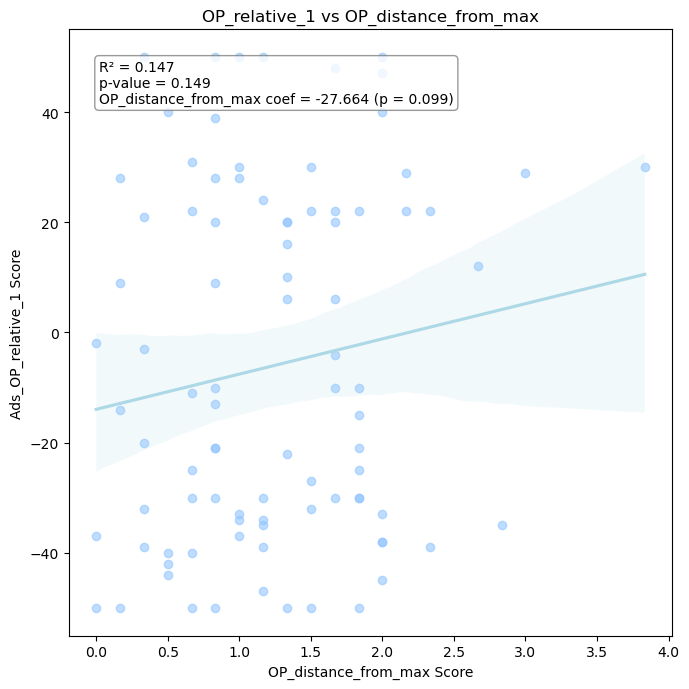


Regression results for Ads_CO_relative_1:
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         32.1071     32.808      0.979      0.331     -33.183      97.397
CO_distance_from_max           6.1435     16.050      0.383      0.703     -25.797      38.084
average_distance               8.6107     26.753      0.322      0.748     -44.629      61.850
gender                        -6.1418      7.221     -0.851      0.398     -20.511       8.228
age                           -0.3154      0.310     -1.017      0.312      -0.933       0.302
education                     -3.3199      3.672     -0.904      0.369     -10.627       3.987
race                          -3.6742      2.794     -1.315      0.192      -9.235       1.887
employment                     1.5905      1.884      0.844      0.401      -2.159       5.340
income 

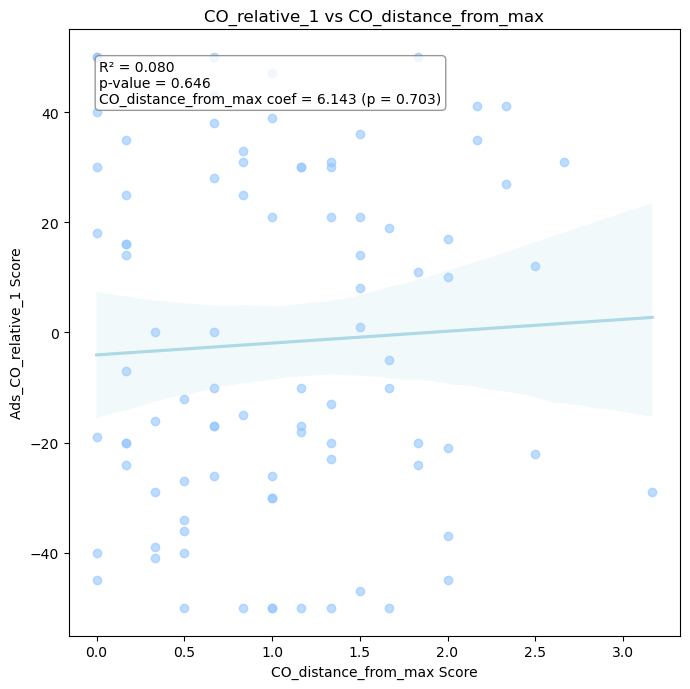


Regression results for Ads_EX_relative_1:
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -61.1156     45.106     -1.355      0.179    -150.879      28.648
EX_distance_from_max          25.0890     16.494      1.521      0.132      -7.736      57.914
average_distance              70.4924     44.102      1.598      0.114     -17.273     158.258
gender                        -4.0332      7.660     -0.527      0.600     -19.278      11.211
age                           -0.2189      0.308     -0.711      0.479      -0.832       0.394
education                      0.6297      3.898      0.162      0.872      -7.128       8.387
race                          -0.0485      2.945     -0.016      0.987      -5.909       5.812
employment                     0.5376      1.955      0.275      0.784      -3.352       4.427
income 

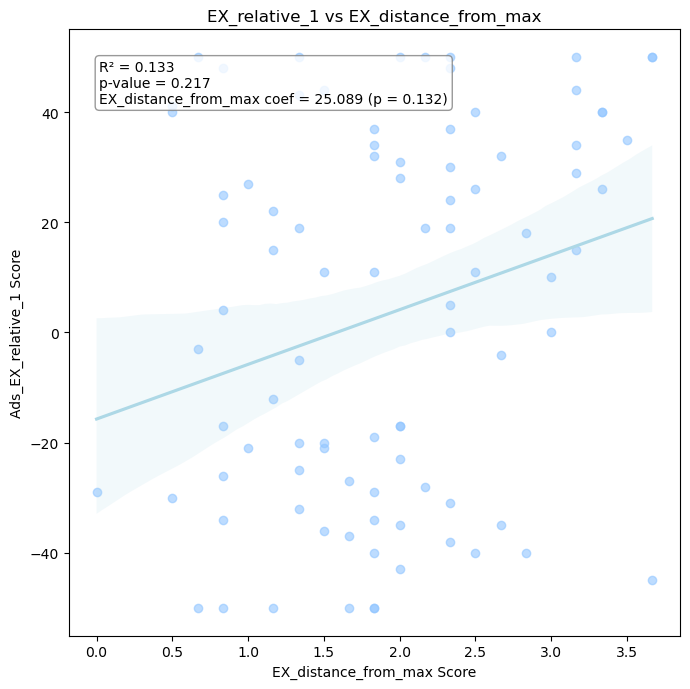


Regression results for Ads_AG_relative_1:
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         18.2008     24.096      0.755      0.452     -29.752      66.153
AG_distance_from_max          -6.9412     12.667     -0.548      0.585     -32.150      18.267
average_distance               1.6335     22.623      0.072      0.943     -43.388      46.655
gender                        -9.6263      6.215     -1.549      0.125     -21.994       2.741
age                           -0.0002      0.252     -0.001      1.000      -0.502       0.502
education                      3.2625      3.142      1.038      0.302      -2.989       9.514
race                          -3.0132      2.374     -1.269      0.208      -7.738       1.712
employment                    -1.1256      1.620     -0.695      0.489      -4.350       2.099
income 

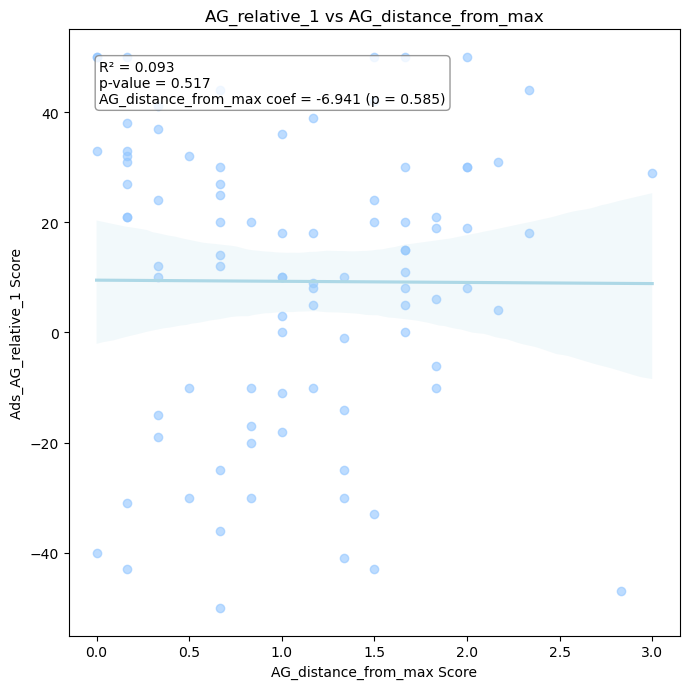

In [83]:
# (DV)         {trait type}_distance_from_max, 
# (primary IV) Ads_{trait type}_relative_1 

traits = ['OP', 'CO', 'EX', 'AG']

for trait in traits:
    # Prepare the data
    X = stmd_merged_df[['{}_distance_from_max'.format(trait), 
                        'average_distance', 
                        'gender', 'age', 'education', 
                        'race', 'employment', 'income']]
    y = stmd_merged_df['Ads_{}_relative_1'.format(trait)]

    # Add interaction term
    X['{}_distance_x_avg_distance'.format(trait)] = X['{}_distance_from_max'.format(trait)] * X['average_distance']
    
    # Add constant term to the features
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Print the summary
    print(f"\nRegression results for Ads_{trait}_relative_1:")
    print(model.summary().tables[1])
    
    # Create scatter plot
    plt.figure(figsize=(7, 7))
    sns.regplot(x='{}_distance_from_max'.format(trait), 
                y='Ads_{}_relative_1'.format(trait), 
                data=stmd_merged_df, 
                scatter_kws={'alpha': 0.6},
                line_kws={'color': 'lightblue'})
    
    plt.title(f'{trait}_relative_1 vs {trait}_distance_from_max')
    plt.xlabel(f'{trait}_distance_from_max Score')
    plt.ylabel(f'Ads_{trait}_relative_1 Score')
    
    # Add annotations
    coef = model.params['{}_distance_from_max'.format(trait)]
    p_value = model.pvalues['{}_distance_from_max'.format(trait)]
    r_squared = model.rsquared
    f_pvalue = model.f_pvalue
    
    annotation = f"R² = {r_squared:.3f}\np-value = {f_pvalue:.3f}\n{trait}_distance_from_max coef = {coef:.3f} (p = {p_value:.3f})"
    plt.annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction',
                 ha='left', va='top',
                 bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()



Regression results for Ads_OP_relative_1 (using average_distance):
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -17.4575     24.305     -0.718      0.475     -65.816      30.902
average_distance         5.5106     14.323      0.385      0.701     -22.988      34.010
OP_distance_from_max     6.1938      4.862      1.274      0.206      -3.481      15.868
gender                  -6.1434      7.344     -0.837      0.405     -20.756       8.469
age                     -0.0317      0.293     -0.108      0.914      -0.616       0.552
education               -4.6044      3.731     -1.234      0.221     -12.027       2.818
race                     2.0067      2.854      0.703      0.484      -3.673       7.686
employment               1.1698      1.885      0.620      0.537      -2.581       4.921
income                   2.4572      1.152

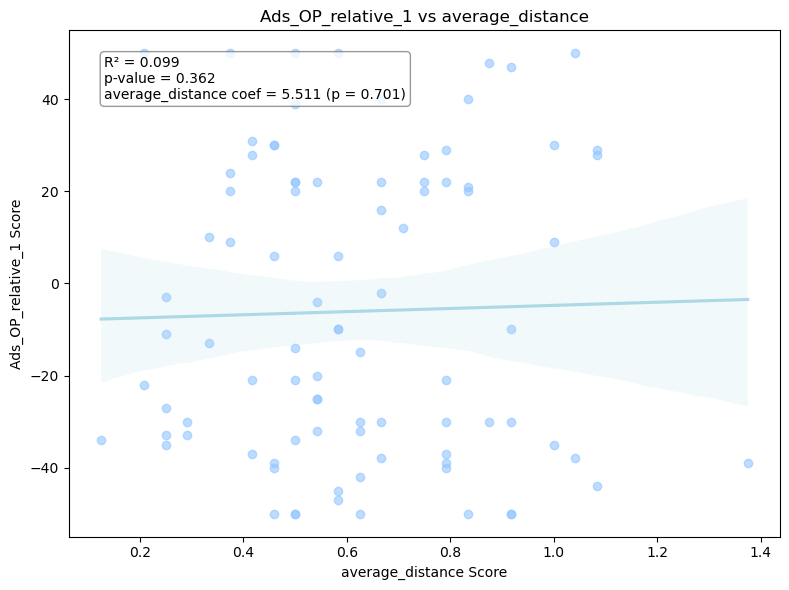


Regression results for Ads_CO_relative_1 (using average_distance):
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   40.4629     24.731      1.636      0.106      -8.743      89.669
average_distance        -0.2547     14.061     -0.018      0.986     -28.232      27.723
CO_distance_from_max     0.1740      4.843      0.036      0.971      -9.461       9.809
gender                  -6.3174      7.169     -0.881      0.381     -20.581       7.946
age                     -0.3207      0.308     -1.040      0.301      -0.934       0.293
education               -3.3938      3.648     -0.930      0.355     -10.652       3.864
race                    -3.7462      2.774     -1.351      0.181      -9.265       1.772
employment               1.4645      1.846      0.793      0.430      -2.209       5.138
income                  -1.2936      1.132

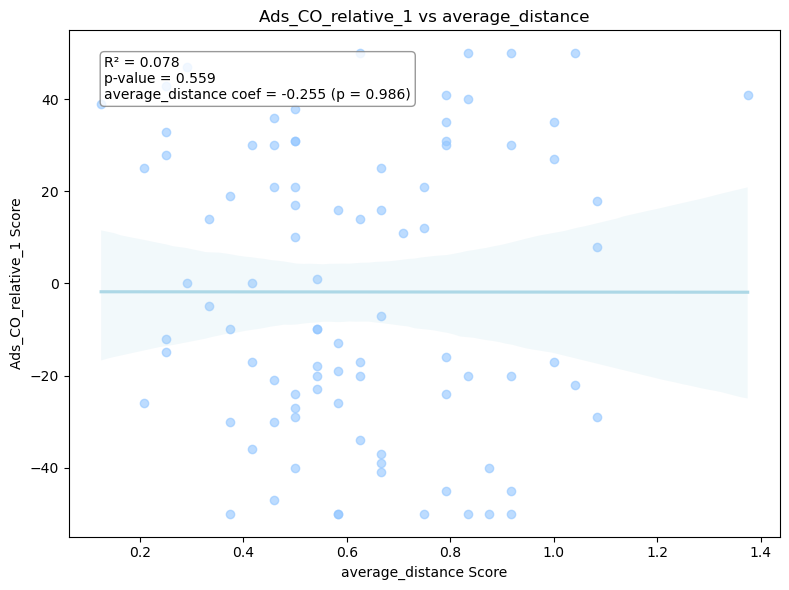


Regression results for Ads_EX_relative_1 (using average_distance):
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -25.6632     26.959     -0.952      0.344     -79.302      27.976
average_distance        29.6546     14.495      2.046      0.044       0.814      58.495
EX_distance_from_max     9.4917      4.358      2.178      0.032       0.820      18.164
gender                  -3.3028      7.622     -0.433      0.666     -18.469      11.863
age                     -0.2278      0.308     -0.740      0.461      -0.840       0.384
education               -0.0906      3.827     -0.024      0.981      -7.706       7.525
race                    -0.3421      2.929     -0.117      0.907      -6.170       5.486
employment               0.3212      1.942      0.165      0.869      -3.542       4.184
income                   0.7888      1.204

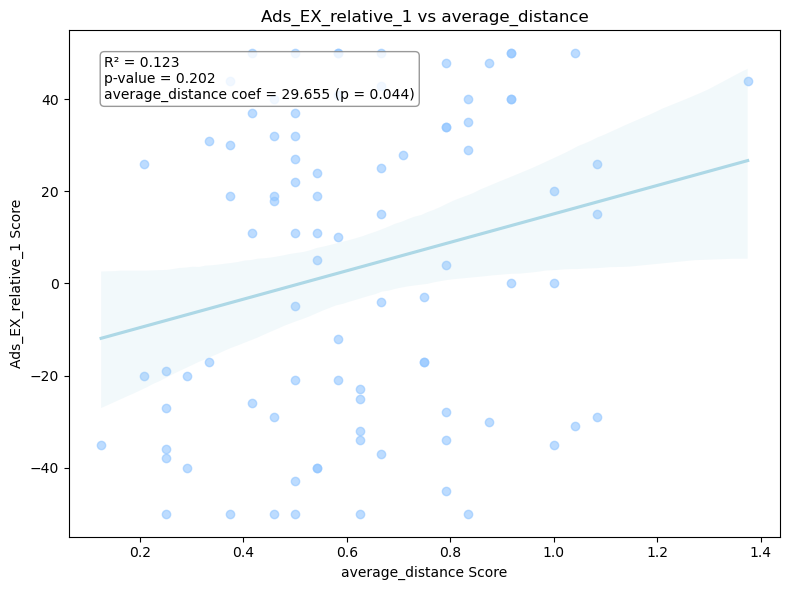


Regression results for Ads_AG_relative_1 (using average_distance):
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   13.2553     19.945      0.665      0.508     -26.429      52.939
average_distance         8.7193     11.990      0.727      0.469     -15.137      32.576
AG_distance_from_max    -2.5368      4.319     -0.587      0.559     -11.130       6.057
gender                  -9.2173      6.083     -1.515      0.134     -21.321       2.886
age                     -0.0223      0.244     -0.092      0.927      -0.507       0.463
education                3.2740      3.125      1.048      0.298      -2.943       9.491
race                    -3.0362      2.361     -1.286      0.202      -7.733       1.661
employment              -1.0284      1.590     -0.647      0.520      -4.192       2.136
income                   0.9135      0.965

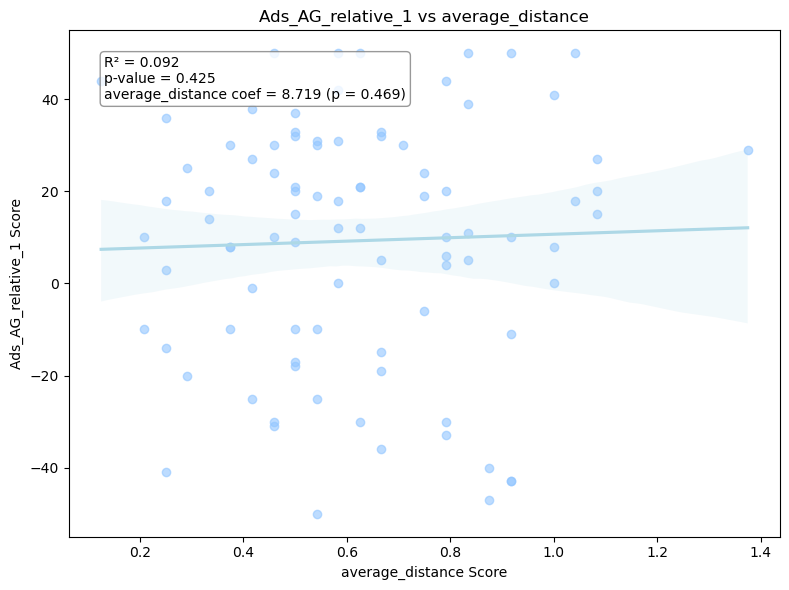

In [84]:
# (DV)         Ads_{trait type}_relative_1 
# (primary IV) average_distance

traits = ['OP', 'CO', 'EX', 'AG']

for trait in traits:
    # Prepare the data
    X = stmd_merged_df[['average_distance', 
                        '{}_distance_from_max'.format(trait),
                        'gender', 'age', 'education', 'race', 'employment', 'income']]
    y = stmd_merged_df['Ads_{}_relative_1'.format(trait)]
    
    # Add constant term to the features
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Print the summary
    print(f"\nRegression results for Ads_{trait}_relative_1 (using average_distance):")
    print(model.summary().tables[1])
    
    # Create scatter plot
    plt.figure(figsize=(8, 6))
    sns.regplot(x='average_distance', 
                y='Ads_{}_relative_1'.format(trait), 
                data=stmd_merged_df, 
                scatter_kws={'alpha': 0.6},
                line_kws={'color': 'lightblue'})
    
    plt.title(f'Ads_{trait}_relative_1 vs average_distance')
    plt.xlabel('average_distance Score')
    plt.ylabel(f'Ads_{trait}_relative_1 Score')
    
    # Add annotations
    coef = model.params['average_distance']
    p_value = model.pvalues['average_distance']
    r_squared = model.rsquared
    f_pvalue = model.f_pvalue
    
    annotation = f"R² = {r_squared:.3f}\np-value = {f_pvalue:.3f}\naverage_distance coef = {coef:.3f} (p = {p_value:.3f})"
    plt.annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction',
                 ha='left', va='top',
                 bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


Regression results for Ads_OP_relative_1:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.6111     22.736      0.247      0.806     -39.617      50.839
Desc_OP_relative_1     0.2877      0.122      2.354      0.021       0.045       0.531
gender                -8.1395      7.071     -1.151      0.253     -22.207       5.928
age                   -0.1239      0.289     -0.428      0.670      -0.699       0.452
education             -3.1112      3.635     -0.856      0.395     -10.342       4.120
race                   2.7014      2.803      0.964      0.338      -2.874       8.277
employment            -0.2187      1.897     -0.115      0.909      -3.993       3.556
income                 1.6223      1.169      1.388      0.169      -0.703       3.948


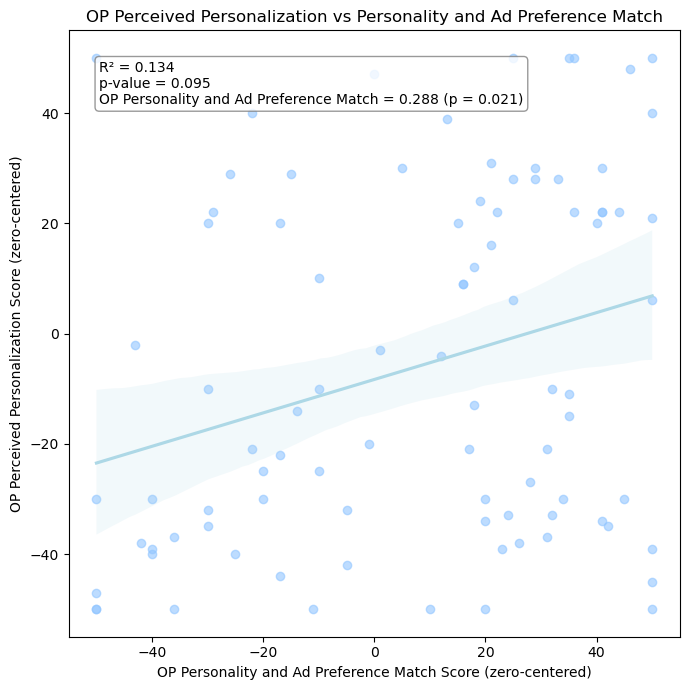


Regression Assumption Checks for OP:
Rainbow test for linearity - statistic: 1.4640, p-value: 0.1178
Durbin-Watson statistic: 1.9932
Breusch-Pagan test p-value: 0.0437

Number of influential points (Cook's distance > 4/n): 2
Shapiro-Wilk test p-value: 0.0245


<Figure size 1000x800 with 0 Axes>

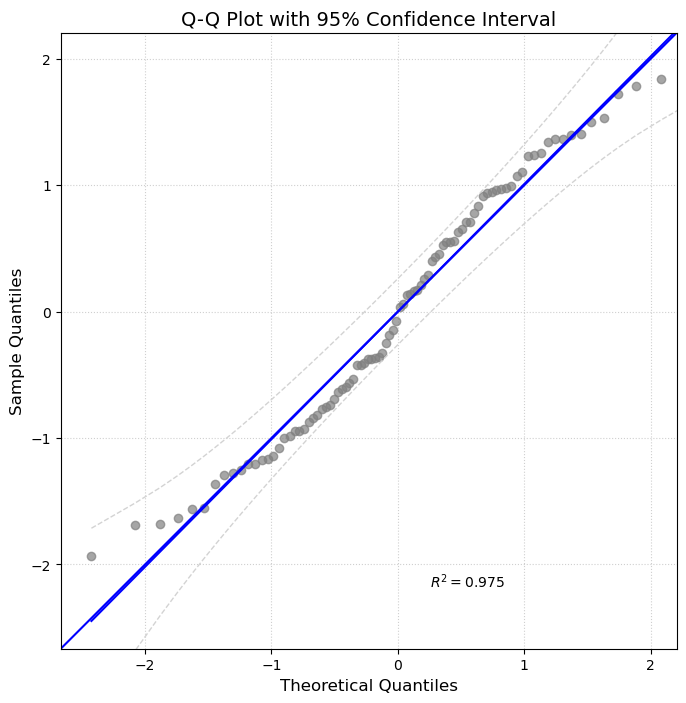


Variance Inflation Factors:
             Variable        VIF
0               const  48.524522
1  Desc_OP_relative_1   1.325029
2              gender   1.171264
3                 age   1.071625
4           education   1.441766
5                race   1.067668
6          employment   1.548139
7              income   1.422192

Maximum VIF: 48.5245 (Variable: const)

Regression results for Ads_CO_relative_1:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 41.8352     22.281      1.878      0.064      -2.488      86.158
Desc_CO_relative_1     0.0611      0.110      0.557      0.579      -0.157       0.279
gender                -7.0492      7.175     -0.983      0.329     -21.322       7.224
age                   -0.3171      0.285     -1.111      0.270      -0.885       0.251
education             -3.4337      3.619     -0.949      0.346     -1

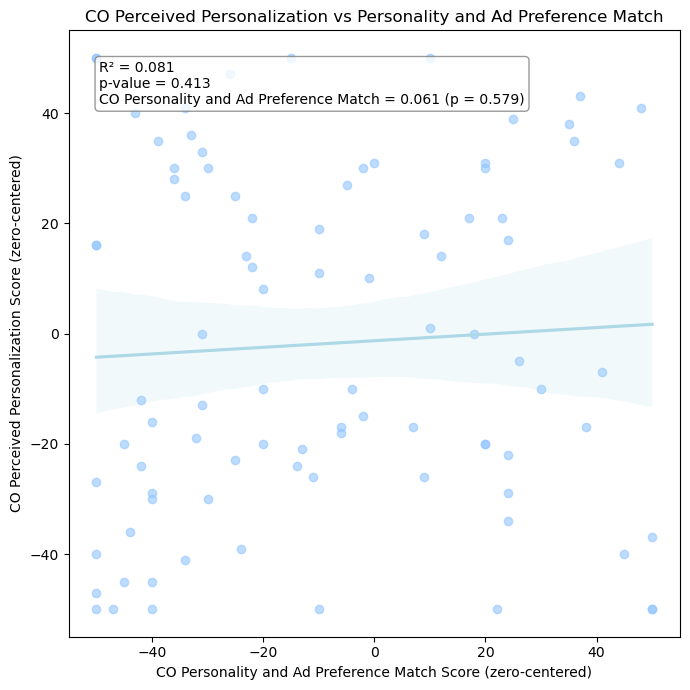


Regression Assumption Checks for CO:
Rainbow test for linearity - statistic: 0.9170, p-value: 0.6121
Durbin-Watson statistic: 1.9669
Breusch-Pagan test p-value: 0.7615

Number of influential points (Cook's distance > 4/n): 5
Shapiro-Wilk test p-value: 0.0192


<Figure size 1000x800 with 0 Axes>

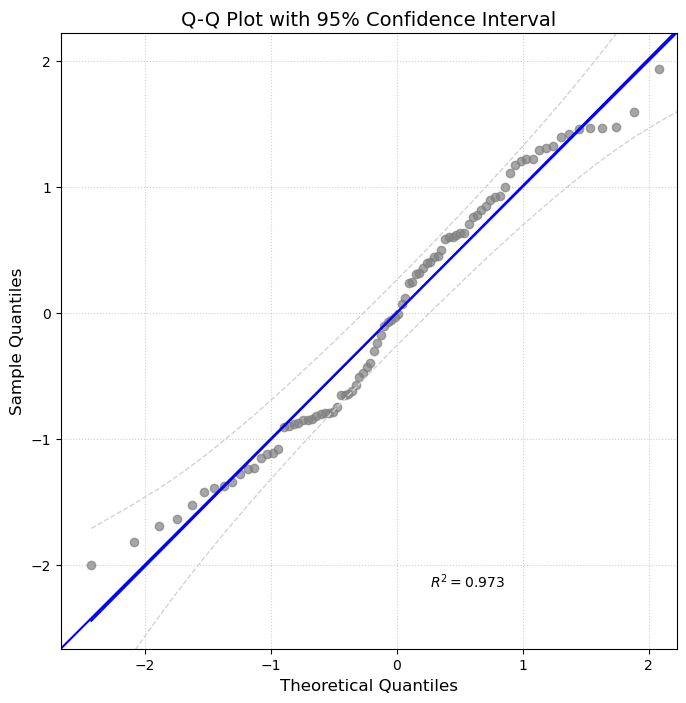


Variance Inflation Factors:
             Variable        VIF
0               const  46.440373
1  Desc_CO_relative_1   1.049872
2              gender   1.201522
3                 age   1.040051
4           education   1.424448
5                race   1.016185
6          employment   1.442115
7              income   1.314088

Maximum VIF: 46.4404 (Variable: const)

Regression results for Ads_EX_relative_1:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 26.3422     24.849      1.060      0.292     -23.091      75.776
Desc_EX_relative_1     0.3048      0.160      1.904      0.060      -0.014       0.623
gender                -1.3156      7.839     -0.168      0.867     -16.910      14.279
age                   -0.4767      0.326     -1.462      0.148      -1.125       0.172
education             -1.1787      3.971     -0.297      0.767      -

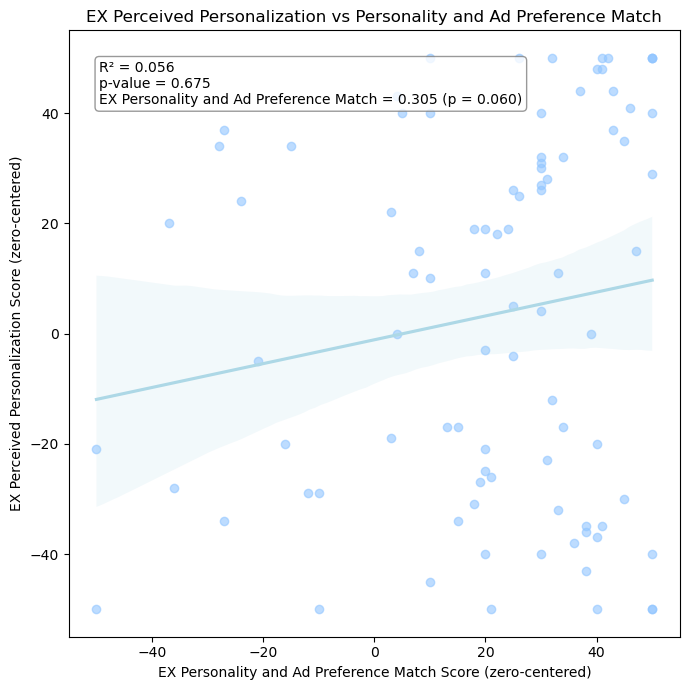


Regression Assumption Checks for EX:
Rainbow test for linearity - statistic: 1.1212, p-value: 0.3627
Durbin-Watson statistic: 1.7877
Breusch-Pagan test p-value: 0.2116

Number of influential points (Cook's distance > 4/n): 4
Shapiro-Wilk test p-value: 0.0007


<Figure size 1000x800 with 0 Axes>

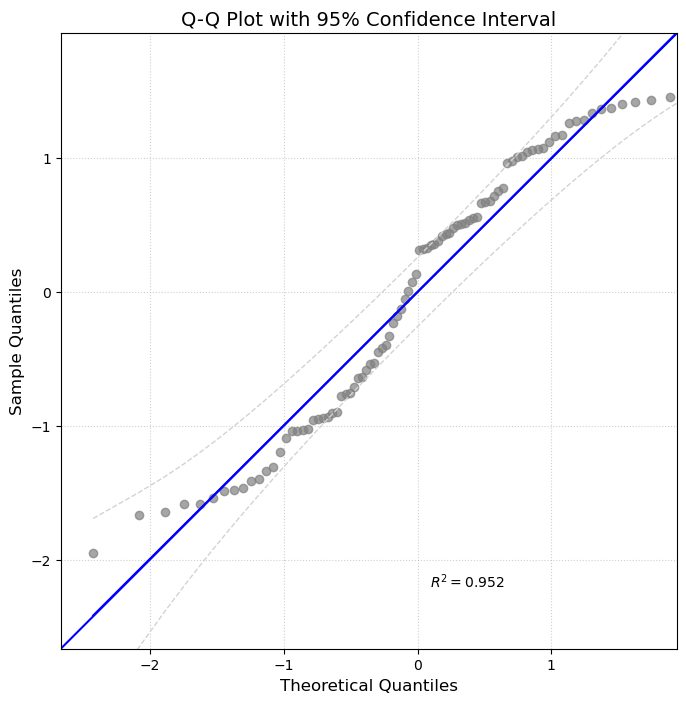


Variance Inflation Factors:
             Variable        VIF
0               const  48.620749
1  Desc_EX_relative_1   1.175253
2              gender   1.207313
3                 age   1.141928
4           education   1.443203
5                race   1.021093
6          employment   1.438209
7              income   1.292476

Maximum VIF: 48.6207 (Variable: const)

Regression results for Ads_AG_relative_1:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 13.6869     19.456      0.703      0.484     -25.018      52.392
Desc_AG_relative_1    -0.0302      0.102     -0.298      0.767      -0.232       0.172
gender                -8.5601      6.024     -1.421      0.159     -20.544       3.423
age                    0.0226      0.251      0.090      0.929      -0.478       0.523
education              3.2106      3.189      1.007      0.317      -

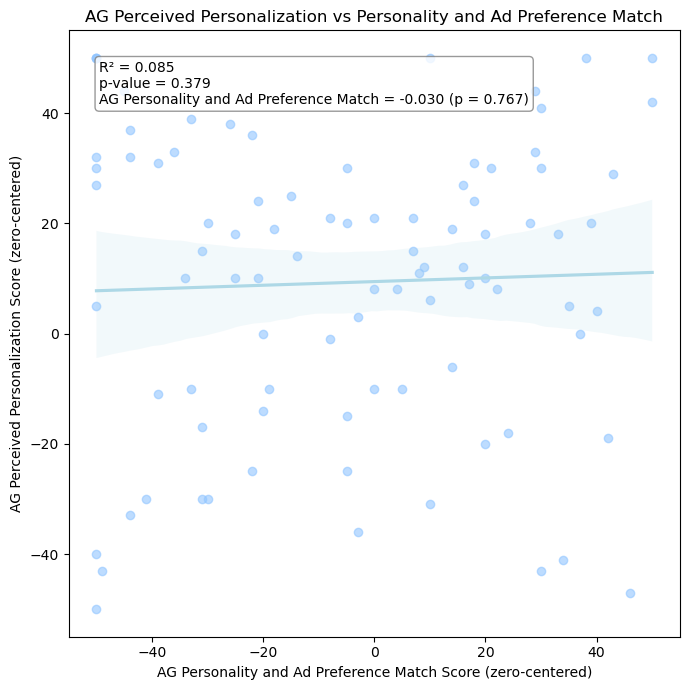


Regression Assumption Checks for AG:
Rainbow test for linearity - statistic: 1.1536, p-value: 0.3296
Durbin-Watson statistic: 1.8962
Breusch-Pagan test p-value: 0.0822

Number of influential points (Cook's distance > 4/n): 11
Shapiro-Wilk test p-value: 0.0918


<Figure size 1000x800 with 0 Axes>

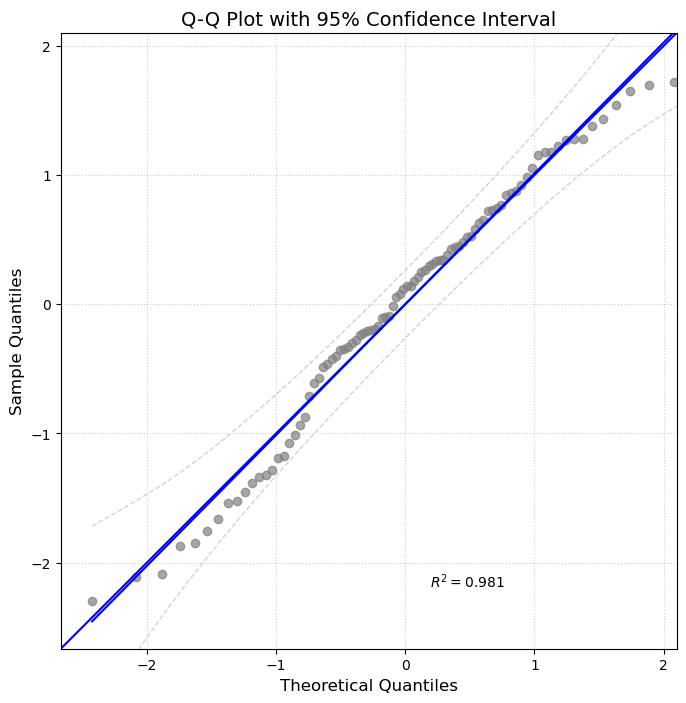


Variance Inflation Factors:
             Variable        VIF
0               const  49.373516
1  Desc_AG_relative_1   1.212528
2              gender   1.180901
3                 age   1.124718
4           education   1.541604
5                race   1.016247
6          employment   1.462656
7              income   1.305733

Maximum VIF: 49.3735 (Variable: const)


In [85]:
# (DV)          Ads_{trait type}_relative_1, 
# (primary IV) 	Desc_{trait type}_relative_1

traits = ['OP', 'CO', 'EX', 'AG']

for trait in traits:
    # Prepare the data
    X = stmd_merged_df[['Desc_{}_relative_1'.format(trait), 'gender', 'age', 'education', 'race', 'employment', 'income']]
    y = stmd_merged_df['Ads_{}_relative_1'.format(trait)]
    
    # Add constant term to the features
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Print the summary
    print(f"\nRegression results for Ads_{trait}_relative_1:")
    print(model.summary().tables[1])
    
    # Create scatter plot
    plt.figure(figsize=(7, 7))
    sns.regplot(x='Desc_{}_relative_1'.format(trait), 
                y='Ads_{}_relative_1'.format(trait), 
                data=stmd_merged_df, 
                scatter_kws={'alpha': 0.6},
                line_kws={'color': 'lightblue'})
    
    plt.title(f'{trait} Perceived Personalization vs Personality and Ad Preference Match')
    plt.xlabel(f'{trait} Personality and Ad Preference Match Score (zero-centered)')
    plt.ylabel(f'{trait} Perceived Personalization Score (zero-centered)')
    
    # Add annotations
    coef = model.params['Desc_{}_relative_1'.format(trait)]
    p_value = model.pvalues['Desc_{}_relative_1'.format(trait)]
    r_squared = model.rsquared
    f_pvalue = model.f_pvalue
    
    annotation = f"R² = {r_squared:.3f}\np-value = {f_pvalue:.3f}\n{trait} Personality and Ad Preference Match = {coef:.3f} (p = {p_value:.3f})"
    plt.annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction',
                 ha='left', va='top',
                 bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

    # Check regression assumptions
    print(f"\nRegression Assumption Checks for {trait}:")
    assumption_results = check_regression_assumptions(model, X, y)
    

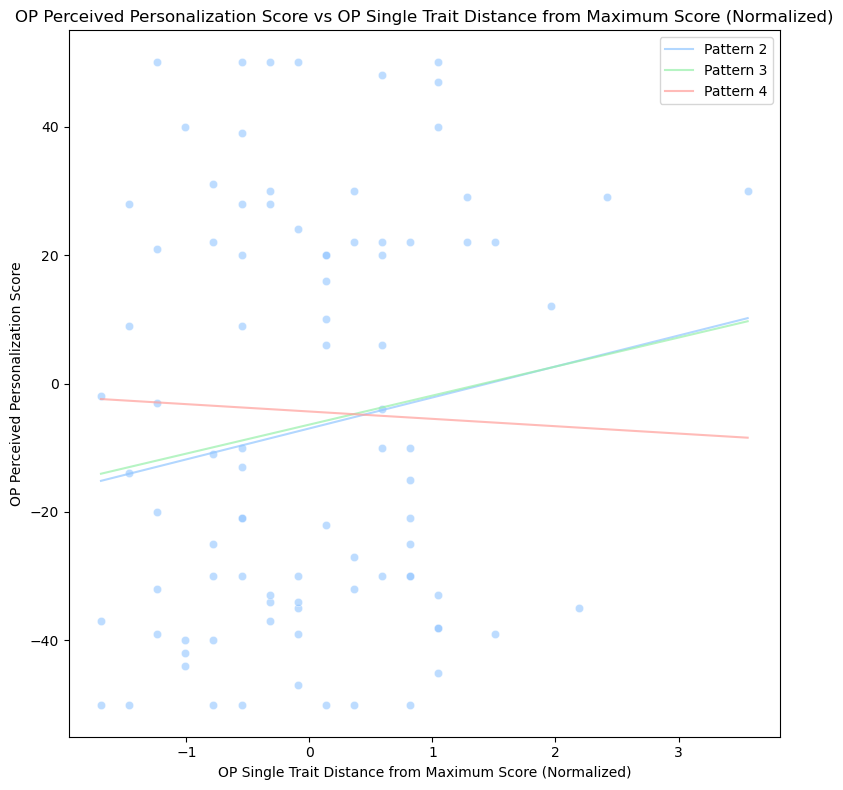

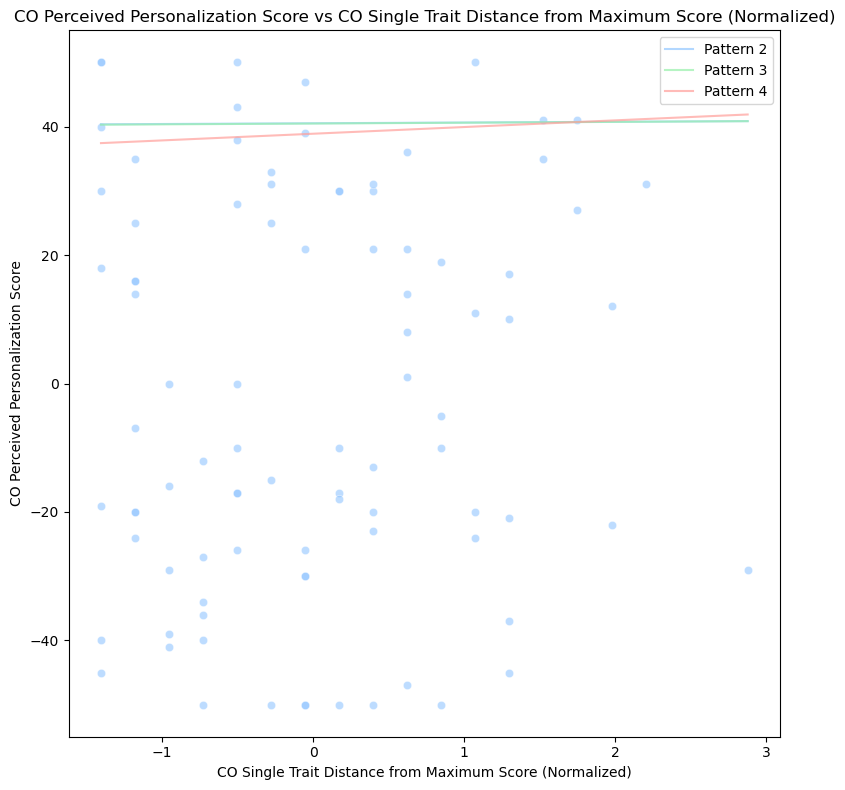

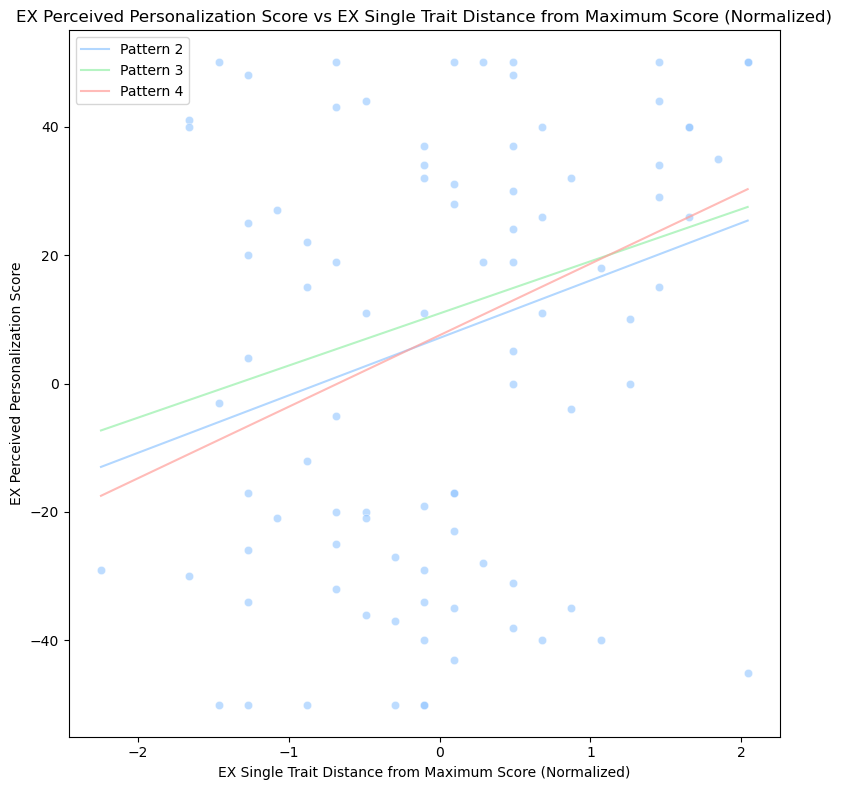

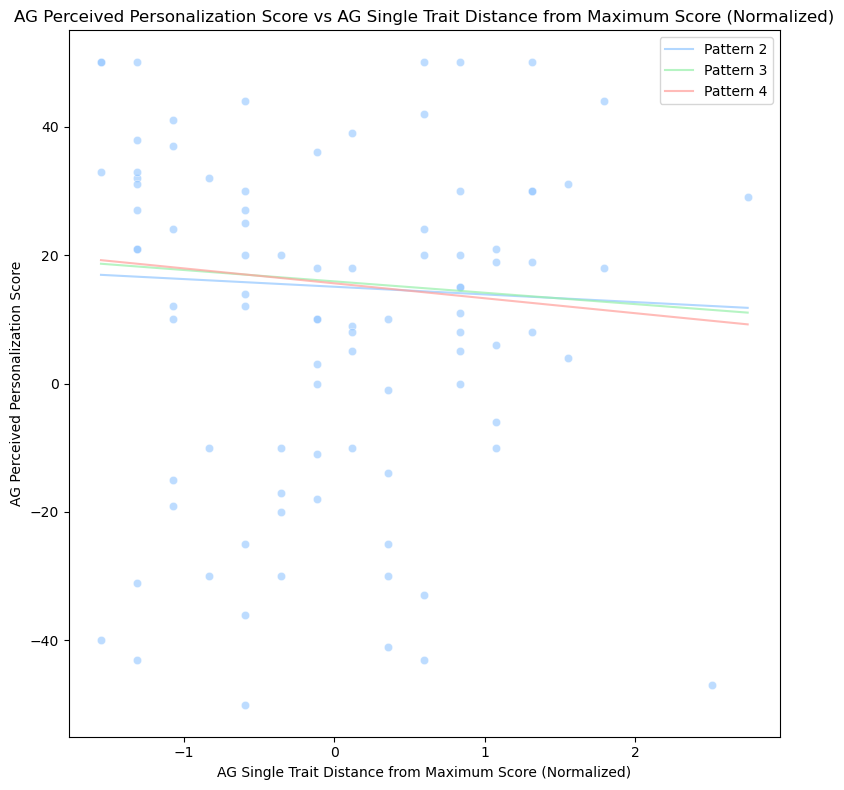


Summary for {}_distance_from_max:
                                      R2  Model_p  Primary_var_coef  Primary_var_p  Secondary_var_coef  Secondary_var_p  Interaction_coef  Interaction_p
Primary_var          Trait Pattern                                                                                                                      
OP_distance_from_max OP    2       0.098    0.277             4.821          0.165                 NaN              NaN               NaN            NaN
                           3       0.099    0.362             4.518          0.206               1.354            0.701               NaN            NaN
                           4       0.147    0.149            -1.145          0.794               2.465            0.481             7.555          0.036
CO_distance_from_max CO    2       0.078    0.446             0.115          0.974                 NaN              NaN               NaN            NaN
                           3       0.078    0.5

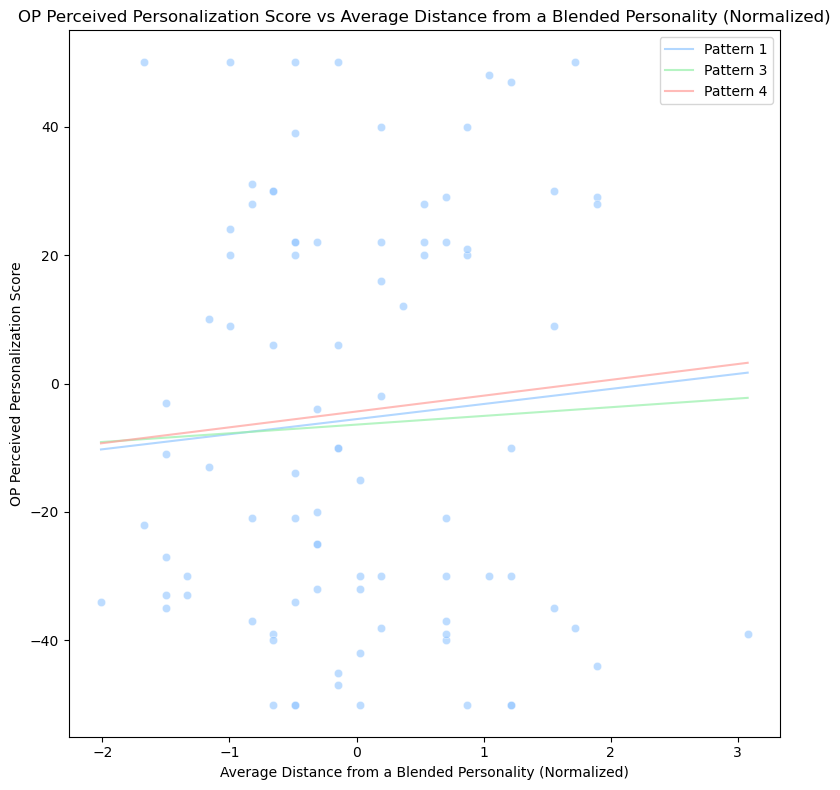

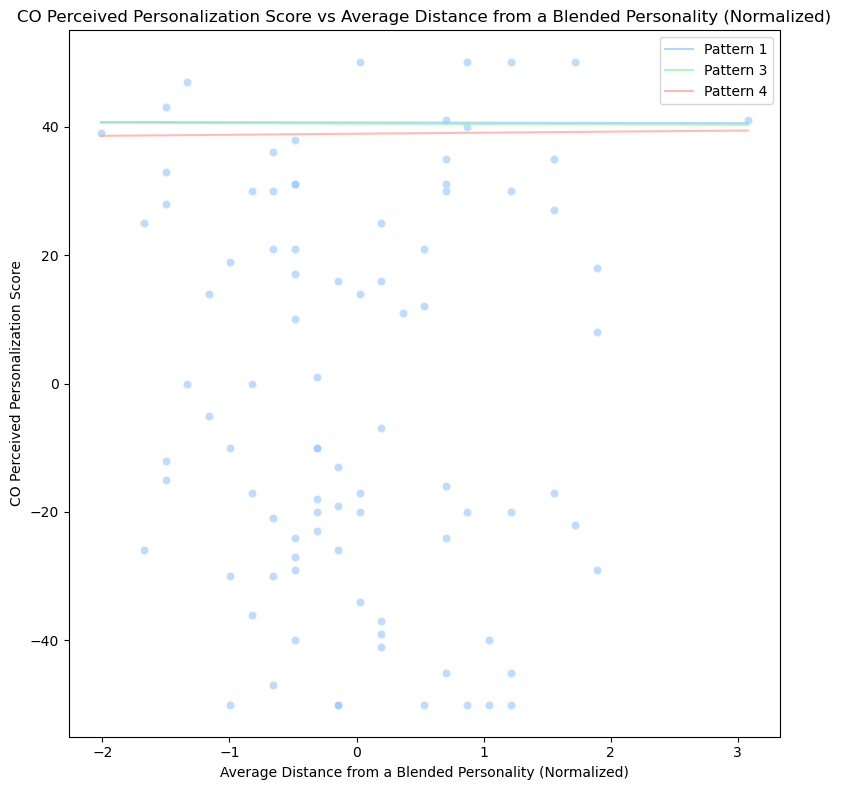

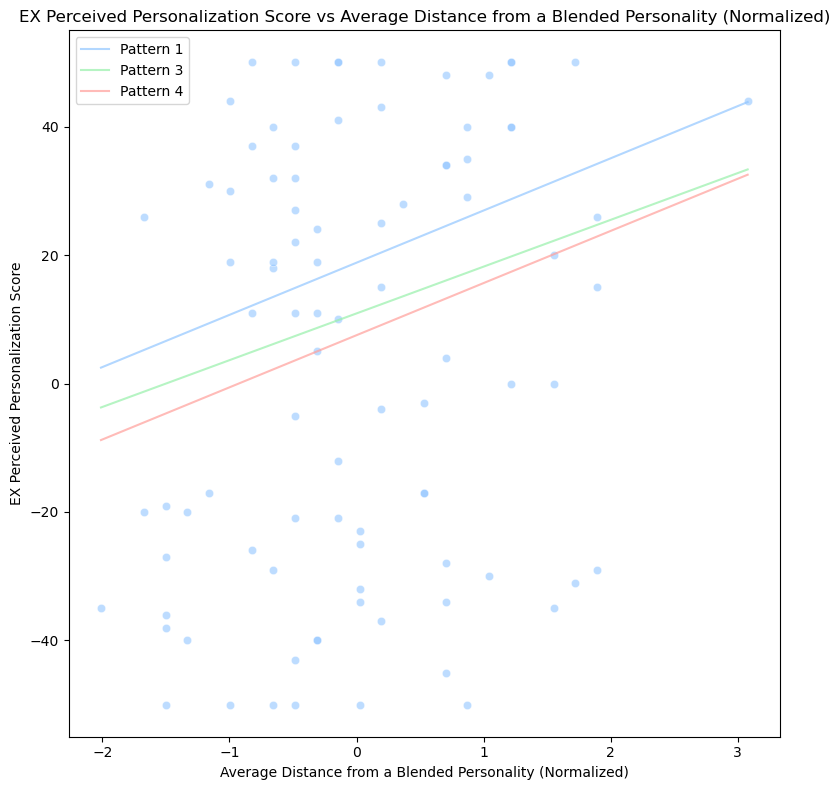

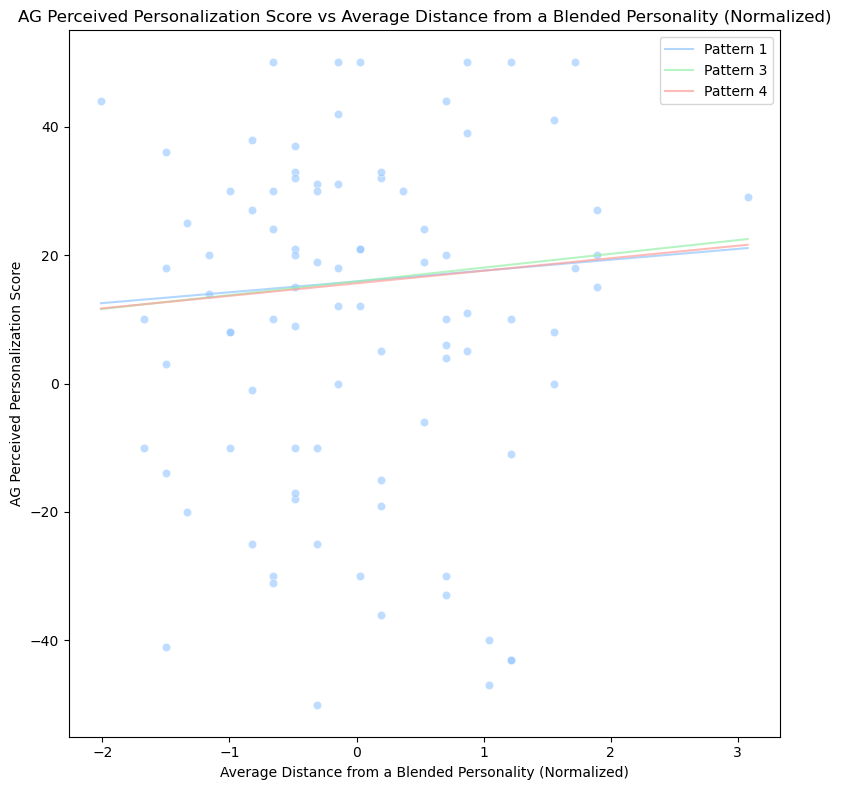


Summary for average_distance:
                                  R2  Model_p  Primary_var_coef  Primary_var_p  Secondary_var_coef  Secondary_var_p  Interaction_coef  Interaction_p
Primary_var      Trait Pattern                                                                                                                      
average_distance OP    1       0.081    0.414             2.351          0.497                 NaN              NaN               NaN            NaN
                       3       0.099    0.362             1.354          0.701               4.518            0.206               NaN            NaN
                       4       0.147    0.149             2.465          0.481              -1.145            0.794             7.555          0.036
                 CO    1       0.078    0.446            -0.036          0.991                 NaN              NaN               NaN            NaN
                       3       0.078    0.559            -0.063          0.

In [86]:
def run_analysis(primary_var):
    summary_data = []

    # Normalize all relevant variables once, outside the loop
    scaler = StandardScaler()
    for trait in traits:
        stmd_merged_df[f'{trait}_distance_from_max_normalized'] = scaler.fit_transform(stmd_merged_df[[f'{trait}_distance_from_max']])
    stmd_merged_df['average_distance_normalized'] = scaler.fit_transform(stmd_merged_df[['average_distance']])

    for trait in traits:
        # Create scatter plot (using normalized data)
        plt.figure(figsize=(8, 8))
        sns.scatterplot(x=f'{trait}_distance_from_max_normalized' if primary_var == '{}_distance_from_max' else 'average_distance_normalized', 
                        y='Ads_{}_relative_1'.format(trait), 
                        data=stmd_merged_df, 
                        alpha=0.6)

        # Add fitted lines for each pattern
        x_range = np.linspace(stmd_merged_df[f'{trait}_distance_from_max_normalized' if primary_var == '{}_distance_from_max' else 'average_distance_normalized'].min(), 
                              stmd_merged_df[f'{trait}_distance_from_max_normalized' if primary_var == '{}_distance_from_max' else 'average_distance_normalized'].max(), 100)

        for pattern in range(1, 5):
            if (primary_var == '{}_distance_from_max' and pattern == 1) or (primary_var == 'average_distance' and pattern == 2):
                continue  # Skip inappropriate patterns

            # Prepare the data for this specific pattern
            if pattern == 1:  # Only for average_distance
                X = stmd_merged_df[['average_distance_normalized', 'gender', 'age', 'education', 'race', 'employment', 'income']]
            elif pattern == 2:  # Only for {}_distance_from_max
                X = stmd_merged_df[[f'{trait}_distance_from_max_normalized', 'gender', 'age', 'education', 'race', 'employment', 'income']]
            elif pattern in [3, 4]:  # Same for both scenarios
                X = stmd_merged_df[[f'{trait}_distance_from_max_normalized', 'average_distance_normalized', 'gender', 'age', 'education', 'race', 'employment', 'income']]
                if pattern == 4:
                    X['{}_distance_x_avg_distance'.format(trait)] = X[f'{trait}_distance_from_max_normalized'] * X['average_distance_normalized']

            y = stmd_merged_df['Ads_{}_relative_1'.format(trait)]
            
            # Add constant term to the features
            X = sm.add_constant(X)
            
            # Fit the model
            model = sm.OLS(y, X).fit()
            
            # Store results
            primary_var_name = f'{trait}_distance_from_max_normalized' if primary_var == '{}_distance_from_max' else 'average_distance_normalized'
            summary_data.append({
                'Primary_var': primary_var.format(trait) if primary_var == '{}_distance_from_max' else primary_var,
                'Trait': trait,
                'Pattern': pattern,
                'R2': model.rsquared,
                'Model_p': model.f_pvalue,
                'Primary_var_coef': model.params.get(primary_var_name, np.nan),
                'Primary_var_p': model.pvalues.get(primary_var_name, np.nan),
                'Secondary_var_coef': model.params.get('average_distance_normalized' if primary_var == '{}_distance_from_max' else f'{trait}_distance_from_max_normalized', np.nan),
                'Secondary_var_p': model.pvalues.get('average_distance_normalized' if primary_var == '{}_distance_from_max' else f'{trait}_distance_from_max_normalized', np.nan),
                'Interaction_coef': model.params.get('{}_distance_x_avg_distance'.format(trait), np.nan),
                'Interaction_p': model.pvalues.get('{}_distance_x_avg_distance'.format(trait), np.nan)
            })

            # Calculate predicted values
            if pattern == 1:  # Only for average_distance
                y_pred = model.params['average_distance_normalized'] * x_range + model.params['const']
            elif pattern == 2:  # Only for {}_distance_from_max
                y_pred = model.params[f'{trait}_distance_from_max_normalized'] * x_range + model.params['const']
            elif pattern in [3, 4]:  # Same for both scenarios
                primary_coef = model.params[primary_var_name]
                secondary_coef = model.params['average_distance_normalized' if primary_var == '{}_distance_from_max' else f'{trait}_distance_from_max_normalized']
                secondary_mean = stmd_merged_df['average_distance_normalized' if primary_var == '{}_distance_from_max' else f'{trait}_distance_from_max_normalized'].mean()
                
                y_pred = primary_coef * x_range + secondary_coef * secondary_mean + model.params['const']
                
                if pattern == 4:
                    interaction_coef = model.params['{}_distance_x_avg_distance'.format(trait)]
                    y_pred += interaction_coef * x_range * secondary_mean

            plt.plot(x_range, y_pred, label=f'Pattern {pattern}', alpha=0.7)

        title = f'{trait} Perceived Personalization Score vs '
        title += f'{trait} Single Trait Distance from Maximum Score (Normalized)' if primary_var == '{}_distance_from_max' else 'Average Distance from a Blended Personality (Normalized)'
        plt.title(title)

        xlabel = f'{trait} Single Trait Distance from Maximum Score (Normalized)' if primary_var == '{}_distance_from_max' else 'Average Distance from a Blended Personality (Normalized)'
        plt.xlabel(xlabel)

        plt.ylabel(f'{trait} Perceived Personalization Score')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Create and print the summary DataFrame
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.set_index(['Primary_var', 'Trait', 'Pattern'])
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print(f"\nSummary for {primary_var}:")
    print(summary_df.to_string(float_format='{:.3f}'.format))

    return summary_df

# Run analysis for {}_distance_from_max
summary_df_distance = run_analysis('{}_distance_from_max')

# Run analysis for average_distance
summary_df_average = run_analysis('average_distance')

# sandbox 1

In [87]:
data = merged_df

"""
マルチレベルモデルは、個人内での広告タイプの効果と個人間での特性の効果を同時に分析します。
これにより、Blended Personality広告が全体的にどの程度好まれるか、
また特定の特性や条件下でどのように効果が変化するかを理解できます。
"""
# b. マルチレベルモデル
data_long = pd.melt(data, 
                    id_vars=['ResponseId', 'EX_distance_from_max', 'OP_distance_from_max', 
                             'CO_distance_from_max', 'AG_distance_from_max', 'average_distance'],
                    value_vars=[col for col in data.columns if col.startswith('Ads_') and col.endswith(('1', '2', '3', '4', '5', '6'))],
                    var_name='ad_type', value_name='preference_score')

data_long['is_blended'] = ~data_long['ad_type'].str.endswith('1')
data_long['trait'] = data_long['ad_type'].str.split('_').str[1]
data_long['question_type'] = data_long['ad_type'].str.split('_').str[2]

model = smf.mixedlm("preference_score ~ is_blended + trait + question_type + is_blended:trait + average_distance", 
                    data=data_long, groups=data_long["ResponseId"])
results = model.fit()
print(results.summary())

                    Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      preference_score
No. Observations:      4320         Method:                  REML            
No. Groups:            90           Scale:                   688.0615        
Min. group size:       48           Log-Likelihood:          -20343.6394     
Max. group size:       48           Converged:               Yes             
Mean group size:       48.0                                                  
-----------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                       53.850    5.069  10.624 0.000  43.915  63.785
is_blended[T.True]              -0.069    2.395  -0.029 0.977  -4.762   4.624
trait[T.CO]                    -11.111    2.765  -4.019 0.000 -16.530  -5.692
trait[

In [88]:
merged_df_norm.columns

Index(['ResponseId', 'OP_distance', 'OP_distance_from_max', 'CO_distance',
       'CO_distance_from_max', 'EX_distance', 'EX_distance_from_max',
       'AG_distance', 'AG_distance_from_max', 'total_distance',
       'average_distance', 'Ads_OP_1', 'Ads_OP_2', 'Ads_OP_3', 'Ads_OP_4',
       'Ads_OP_5', 'Ads_OP_6', 'Ads_CO_1', 'Ads_CO_2', 'Ads_CO_3', 'Ads_CO_4',
       'Ads_CO_5', 'Ads_CO_6', 'Ads_EX_1', 'Ads_EX_2', 'Ads_EX_3', 'Ads_EX_4',
       'Ads_EX_5', 'Ads_EX_6', 'Ads_AG_1', 'Ads_AG_2', 'Ads_AG_3', 'Ads_AG_4',
       'Ads_AG_5', 'Ads_AG_6', 'Desc_OP_1', 'Desc_CO_1', 'Desc_EX_1',
       'Desc_AG_1', 'gender', 'age', 'education', 'race', 'employment',
       'income', 'Desc_EX_relative_1', 'Ads_EX_relative_1',
       'Ads_EX_relative_2', 'Ads_EX_relative_3', 'Ads_EX_relative_4',
       'Ads_EX_relative_5', 'Ads_EX_relative_6', 'Desc_OP_relative_1',
       'Ads_OP_relative_1', 'Ads_OP_relative_2', 'Ads_OP_relative_3',
       'Ads_OP_relative_4', 'Ads_OP_relative_5', 'Ads_OP_relative_

Cluster Analysis Results:
Cluster 0 (Size: 38):
  - EX_distance_from_max: Medium (0.50)
  - OP_distance_from_max: Low (0.27)
  - CO_distance_from_max: Medium (0.37)
  - AG_distance_from_max: Medium (0.40)
  - average_distance: Low (0.23)

Cluster 1 (Size: 30):
  - EX_distance_from_max: Medium (0.42)
  - OP_distance_from_max: Low (0.31)
  - CO_distance_from_max: Low (0.08)
  - AG_distance_from_max: Low (0.19)
  - average_distance: Medium (0.46)

Cluster 2 (Size: 22):
  - EX_distance_from_max: High (0.70)
  - OP_distance_from_max: Medium (0.43)
  - CO_distance_from_max: Medium (0.60)
  - AG_distance_from_max: Medium (0.52)
  - average_distance: Medium (0.59)



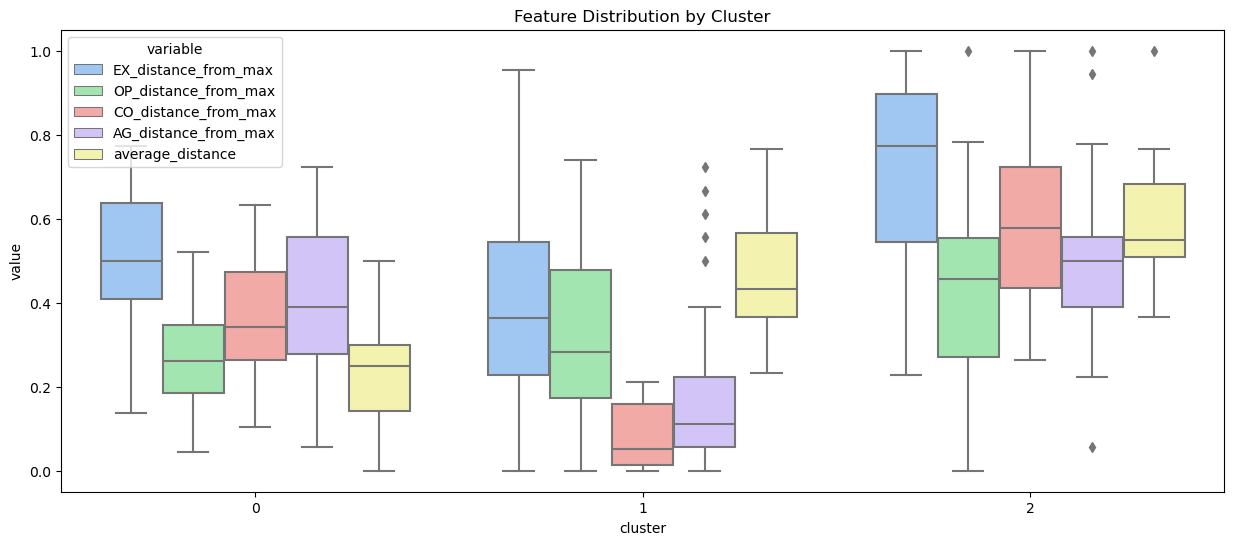


Ad Preference Analysis by Cluster:
          Ads_OP_1   Ads_CO_1   Ads_EX_1   Ads_AG_1
cluster                                            
0        45.210526  50.842105  47.736842  55.894737
1        39.800000  45.066667  54.133333  68.200000
2        47.409091  47.727273  61.954545  52.909091


In [89]:
"""
潜在クラス分析は、回答者を類似した特性と広告選好を持つグループに分類します。
これにより、Blended Personality広告がどのようなタイプの人々により効果的であるかを
探索的に理解することができ、GPT-4の広告生成能力の強みと限界を明らかにするのに役立ちます。
"""

data = merged_df_norm

# c. 潜在クラス分析（ここではGaussian Mixture Modelを使用）
# 特徴量の選択
features = ['EX_distance_from_max', 'OP_distance_from_max', 
            'CO_distance_from_max', 'AG_distance_from_max', 
            'average_distance']
X = data[features]
X_scaled = StandardScaler().fit_transform(X)

# モデルの適合
gmm = GaussianMixture(n_components=3, random_state=42)
data['cluster'] = gmm.fit_predict(X_scaled)

# クラスターごとの特徴を分析
cluster_means = data.groupby('cluster')[features].mean()
cluster_sizes = data['cluster'].value_counts().sort_index()

# クラスターの特徴を記述
cluster_descriptions = []
for i in range(3):
    description = f"Cluster {i} (Size: {cluster_sizes[i]}):\n"
    for feature in features:
        value = cluster_means.loc[i, feature]
        if value < 0.33:
            level = "Low"
        elif value < 0.66:
            level = "Medium"
        else:
            level = "High"
        description += f"  - {feature}: {level} ({value:.2f})\n"
    cluster_descriptions.append(description)

# 結果の表示
print("Cluster Analysis Results:")
for desc in cluster_descriptions:
    print(desc)

# クラスターごとの特徴を可視化
plt.figure(figsize=(15, 6))
sns.boxplot(x='cluster', y='value', hue='variable', 
            data=pd.melt(data[features + ['cluster']], id_vars='cluster'))
plt.title('Feature Distribution by Cluster')
plt.show()

# 各クラスターの広告選好スコアの分析
ad_preference_columns = ['Ads_OP_1', 'Ads_CO_1', 'Ads_EX_1', 'Ads_AG_1']
cluster_ad_preferences = data.groupby('cluster')[ad_preference_columns].mean()

print("\nAd Preference Analysis by Cluster:")
print(cluster_ad_preferences)

In [90]:
"""
閾値を用いた分析は、Blended Personality広告の効果が特定の条件下で
どのように変化するかを明らかにします。これは、GPT-4が生成する広告の
効果が、ターゲットとなる個人の特性プロファイルにどの程度依存するかを
理解するのに役立ちます。
"""

# d. 閾値を用いた分析
data['high_average_distance'] = data['average_distance'] > data['average_distance'].median()

for trait in ['EX', 'OP', 'CO', 'AG']:
    t_stat, p_value = stats.ttest_ind(
        data[data['high_average_distance']][f'{trait}_distance_from_max'],
        data[~data['high_average_distance']][f'{trait}_distance_from_max']
    )
    print(f"\n{trait} - T-test for diff_score between high and low average_distance groups:")
    print(f"T-statistic: {t_stat}, P-value: {p_value}")


EX - T-test for diff_score between high and low average_distance groups:
T-statistic: 0.5110244644294054, P-value: 0.6106136565091842

OP - T-test for diff_score between high and low average_distance groups:
T-statistic: 2.0663022737233403, P-value: 0.041739572451391316

CO - T-test for diff_score between high and low average_distance groups:
T-statistic: 0.42209045125055644, P-value: 0.6739884283984843

AG - T-test for diff_score between high and low average_distance groups:
T-statistic: 0.24795385903302972, P-value: 0.8047477716211742


# sandbox 2 (final?)


Interaction analysis for EX:
                            OLS Regression Results                            
Dep. Variable:      Ads_EX_relative_1   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     3.460
Date:                Wed, 21 Aug 2024   Prob (F-statistic):             0.0198
Time:                        16:13:20   Log-Likelihood:                -437.85
No. Observations:                  90   AIC:                             883.7
Df Residuals:                      86   BIC:                             893.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

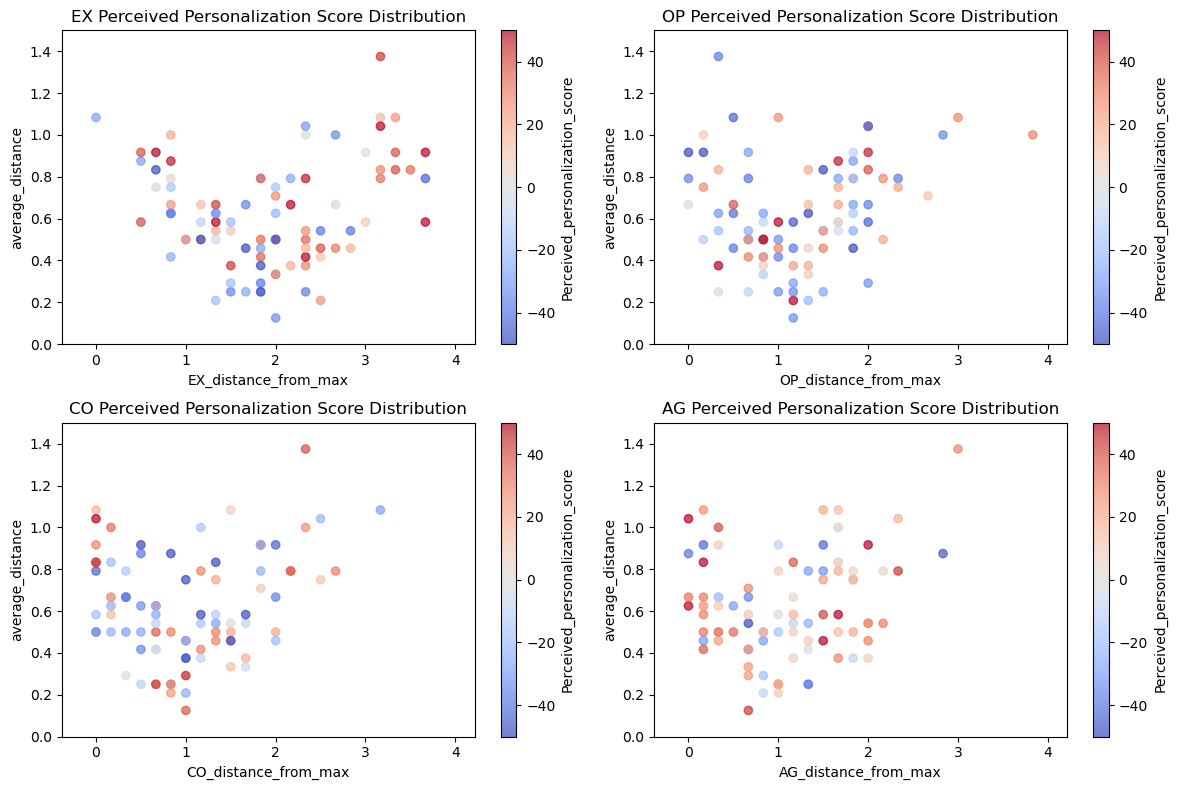

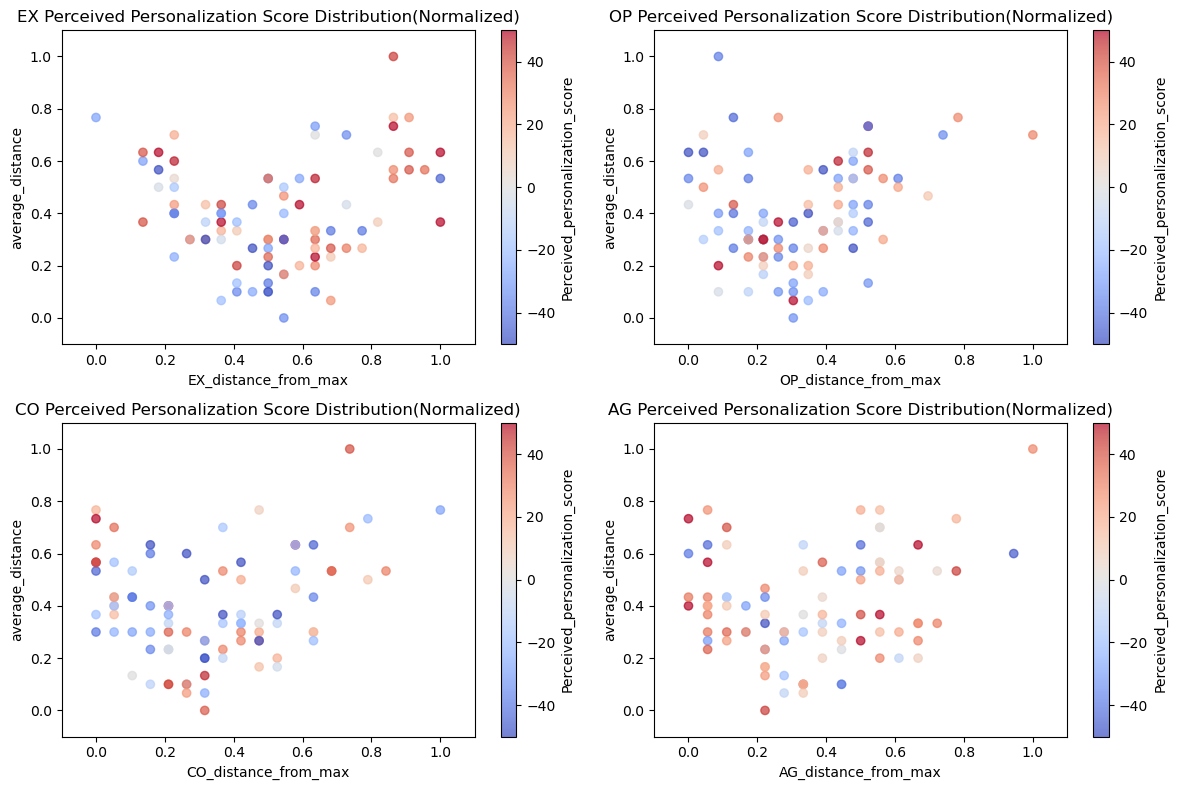

In [91]:
# 6. 交互作用効果の分析
def analyze_interactions(trait, data):
    model = smf.ols(f'Ads_{trait}_relative_1 ~ {trait}_distance_from_max * average_distance', data=data)
    results = model.fit()
    print(f"\nInteraction analysis for {trait}:")
    print(results.summary())

for trait in ['EX', 'OP', 'CO', 'AG']:
    analyze_interactions(trait, merged_df_norm)

# 可視化2
def scatter_plot_2 (data, scaled = ""):
    plt.figure(figsize=(12, 8))

    # 全てのTraitの中での最大値と最小値を計算
    x_min = min(data[f'{trait}_distance_from_max'].min() for trait in ['EX', 'OP', 'CO', 'AG'])
    x_max = max(data[f'{trait}_distance_from_max'].max() for trait in ['EX', 'OP', 'CO', 'AG'])
    y_min = data['average_distance'].min()
    y_max = data['average_distance'].max()

    # マージンを追加
    margin = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= margin * x_range
    x_max += margin * x_range
    y_min -= margin * y_range
    y_max += margin * y_range

    for i, trait in enumerate(['EX', 'OP', 'CO', 'AG']):
        plt.subplot(2, 2, i+1)
        
        scatter = plt.scatter(data[f'{trait}_distance_from_max'], 
                            data['average_distance'],
                            c=data[f'Ads_{trait}_relative_1'], 
                            cmap='coolwarm', 
                            alpha=0.7)
        plt.colorbar(scatter, label=f'Perceived_personalization_score')
        plt.xlabel(f'{trait}_distance_from_max')
        plt.ylabel('average_distance')
        plt.title(f'{trait} Perceived Personalization Score Distribution{scaled}')
        
        # 全てのチャートで同じX軸とY軸の範囲を設定
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

scatter_plot_2 (merged_df, scaled = "")
scatter_plot_2 (merged_df_norm, scaled = '(Normalized)')



In [92]:
merged_df_norm.tail(1)

ResponseId  OP_distance  OP_distance_from_max  CO_distance  \
89  6658822c0f5b1367a1585ee1         0.25              0.478261     0.461538   

    CO_distance_from_max  EX_distance  EX_distance_from_max  AG_distance  \
89                   0.0     0.727273              0.136364     0.333333   

    AG_distance_from_max  total_distance  average_distance  Ads_OP_1  \
89              0.111111        0.633333          0.633333        40   

    Ads_OP_2  Ads_OP_3  Ads_OP_4  Ads_OP_5  Ads_OP_6  Ads_CO_1  Ads_CO_2  \
89        50        40        40        40        40        80        80   

    Ads_CO_3  Ads_CO_4  Ads_CO_5  Ads_CO_6  Ads_EX_1  Ads_EX_2  Ads_EX_3  \
89        80        85        90        90        90        50        90   

    Ads_EX_4  Ads_EX_5  Ads_EX_6  Ads_AG_1  Ads_AG_2  Ads_AG_3  Ads_AG_4  \
89        80       100        90        60        70        60        50   

    Ads_AG_5  Ads_AG_6  Desc_OP_1  Desc_CO_1  Desc_EX_1  Desc_AG_1  gender  \
89        70        70         40         70         60         70       2   

    age  education  race  employment  income  Desc_EX_relative_1  \
89   43          5     2           7       8                  10   

    Ads_EX_relative_1  Ads_EX_relative_2  Ads_EX_relative_3  \
89                 40                  0                 40   

    Ads_EX_relative_4  Ads_EX_relative_5  Ads_EX_relative_6  \
89                 30                 50                 40   

    Desc_OP_relative_1  Ads_OP_relative_1  Ads_OP_relative_2  \
89                 -10                -10                  0   

    Ads_OP_relative_3  Ads_OP_relative_4  Ads_OP_relative_5  \
89                -10                -10                -10   

    Ads_OP_relative_6  Desc_CO_relative_1  Ads_CO_relative_1  \
89                -10                  20                 30   

    Ads_CO_relative_2  Ads_CO_relative_3  Ads_CO_relative_4  \
89                 30                 30                 35   

    Ads_CO_relative_5  Ads_CO_relative_6  Desc_AG_relative_1  \
89                 40                 40                  20   

    Ads_AG_relative_1  Ads_AG_relative_2  Ads_AG_relative_3  \
89                 10                 20                 10   

    Ads_AG_relative_4  Ads_AG_relative_5  Ads_AG_relative_6  cluster  \
89                  0                 20                 20        1   

    high_average_distance  
89                   True

In [93]:
merged_df_norm.dtypes

ResponseId                object
OP_distance              float64
OP_distance_from_max     float64
CO_distance              float64
CO_distance_from_max     float64
                          ...   
Ads_AG_relative_4          int64
Ads_AG_relative_5          int64
Ads_AG_relative_6          int64
cluster                    int64
high_average_distance       bool
Length: 75, dtype: object


Analysis Results for EX:

Section: High-High
N: 23
Mean: 13.74
95% CI: (1.39, 26.00)
P-value: 0.0464
Cohen's d: 0.45
Preferred Ad Type: Blended

Section: Low-High
N: 20
Mean: -3.10
95% CI: (-17.65, 11.95)
P-value: 0.6938
Cohen's d: -0.09
Preferred Ad Type: Single Trait

Section: Low-Low
N: 26
Mean: -7.00
95% CI: (-19.35, 5.46)
P-value: 0.2826
Cohen's d: -0.22
Preferred Ad Type: Single Trait

Section: High-Low
N: 21
Mean: 10.90
95% CI: (-3.29, 23.76)
P-value: 0.1414
Cohen's d: 0.34
Preferred Ad Type: Blended

Linear Regression Results:
                              OLS Regression Results                              
Dep. Variable:     Q("Ads_EX_relative_1")   R-squared:                       0.115
Model:                                OLS   Adj. R-squared:                  0.073
Method:                     Least Squares   F-statistic:                     2.754
Date:                    Wed, 21 Aug 2024   Prob (F-statistic):             0.0331
Time:                            16:13:25  

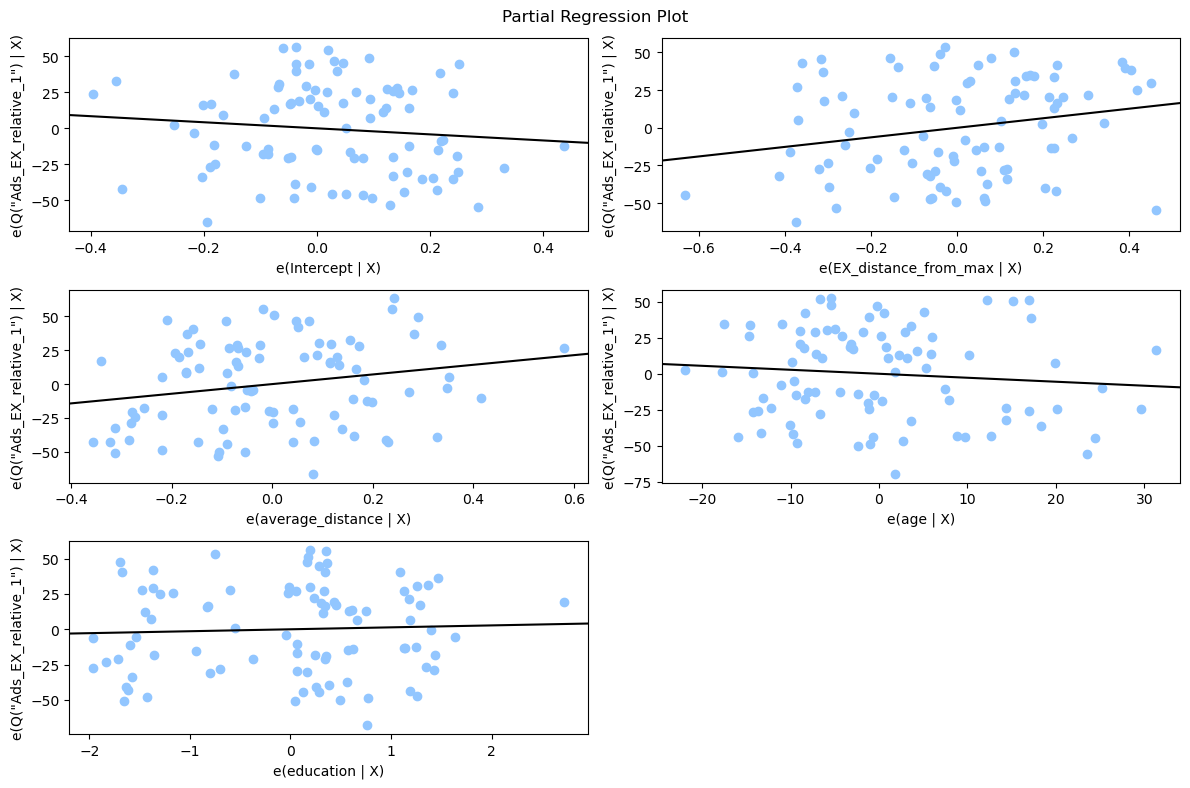

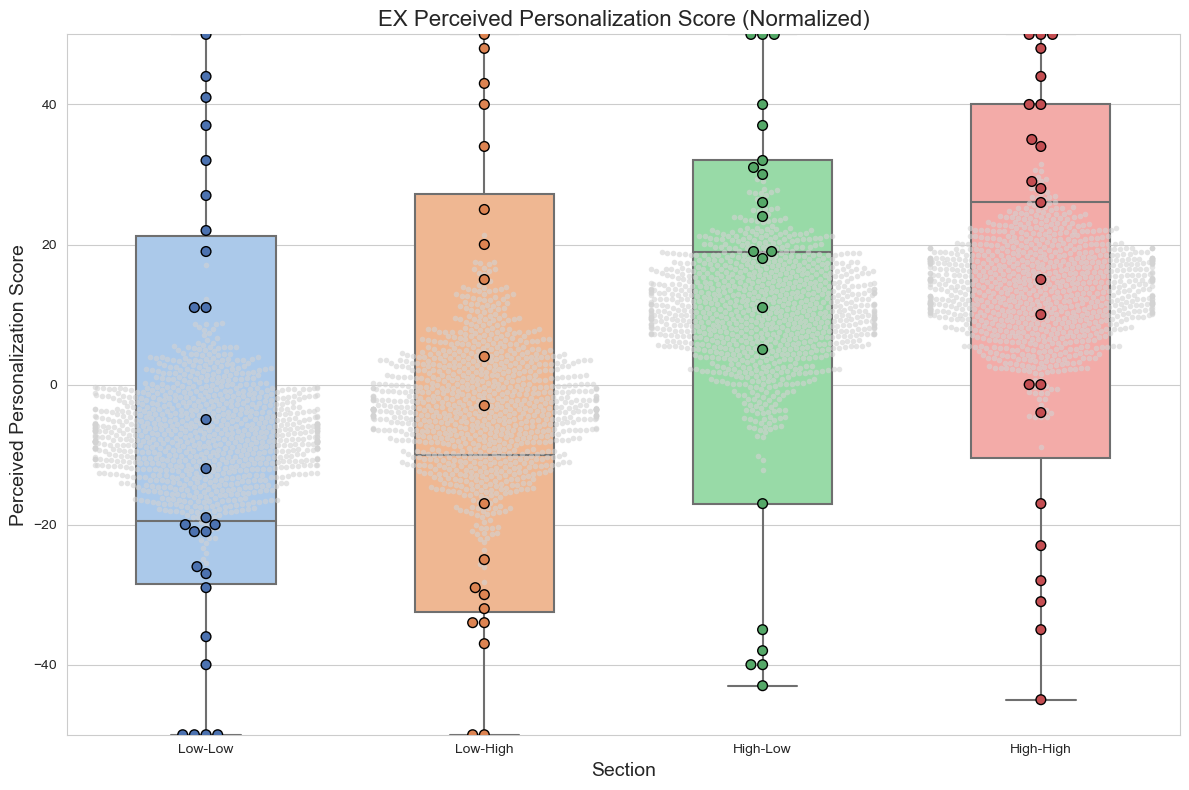


Analysis Results for OP:

Section: High-High
N: 27
Mean: 0.41
95% CI: (-11.85, 12.70)
P-value: 0.9491
Cohen's d: 0.01
Preferred Ad Type: Blended

Section: Low-High
N: 16
Mean: -16.88
95% CI: (-31.25, -1.62)
P-value: 0.0507
Cohen's d: -0.55
Preferred Ad Type: Single Trait

Section: Low-Low
N: 32
Mean: -5.12
95% CI: (-16.47, 6.38)
P-value: 0.3921
Cohen's d: -0.16
Preferred Ad Type: Single Trait

Section: High-Low
N: 15
Mean: -8.13
95% CI: (-20.53, 4.67)
P-value: 0.2568
Cohen's d: -0.32
Preferred Ad Type: Single Trait

Linear Regression Results:
                              OLS Regression Results                              
Dep. Variable:     Q("Ads_OP_relative_1")   R-squared:                       0.024
Model:                                OLS   Adj. R-squared:                 -0.022
Method:                     Least Squares   F-statistic:                    0.5214
Date:                    Wed, 21 Aug 2024   Prob (F-statistic):              0.720
Time:                            16

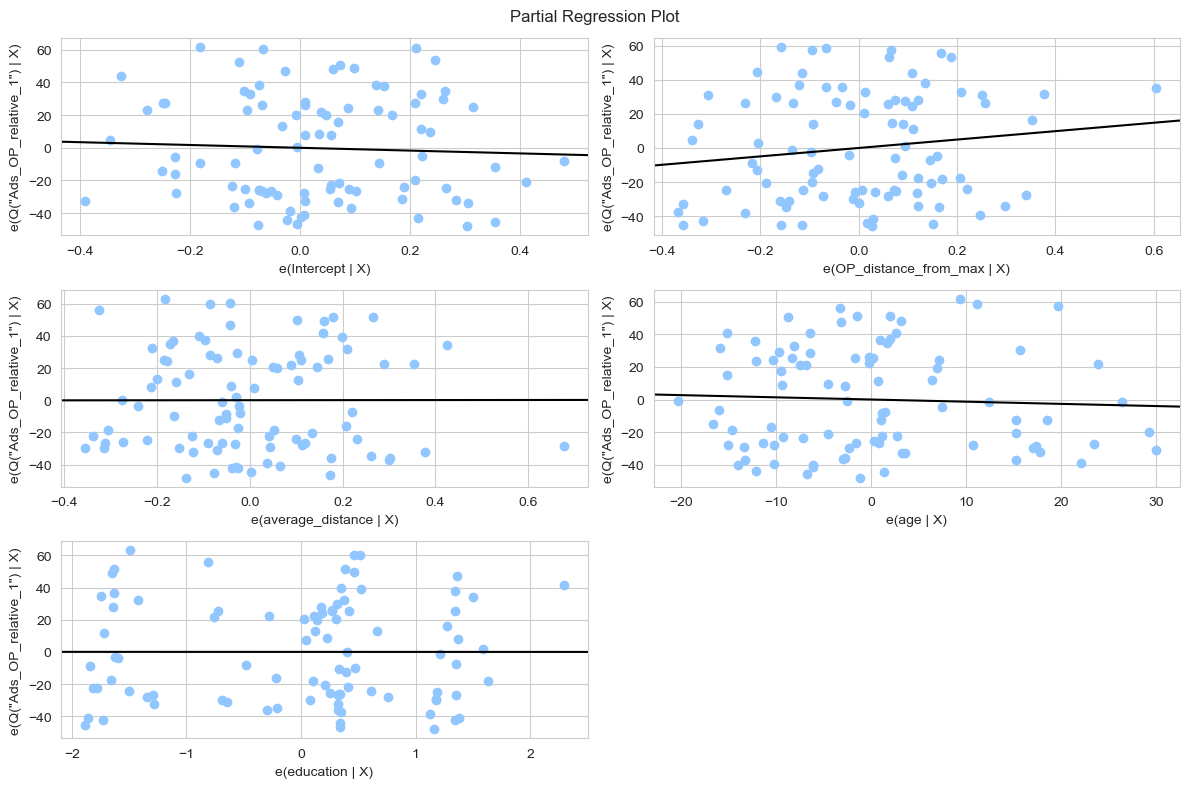

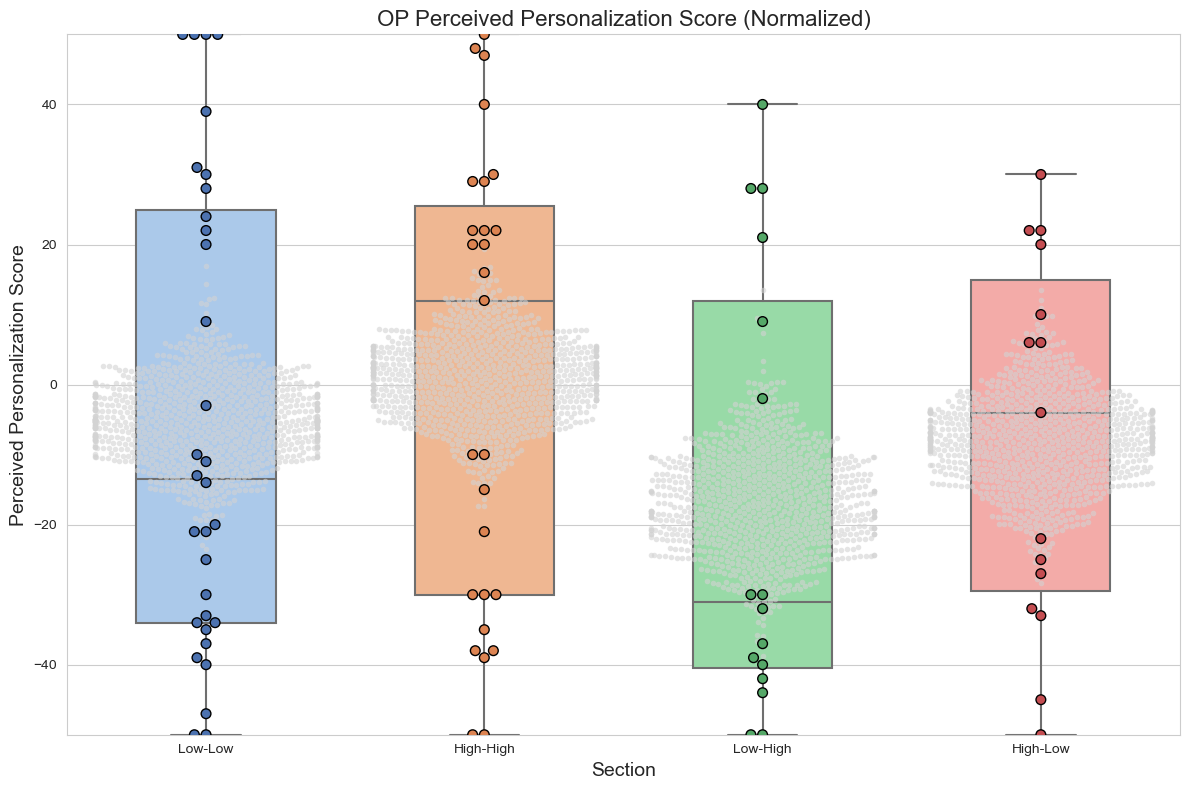


Analysis Results for CO:

Section: High-High
N: 20
Mean: 0.65
95% CI: (-13.80, 14.85)
P-value: 0.9319
Cohen's d: 0.02
Preferred Ad Type: Blended

Section: Low-High
N: 23
Mean: -4.39
95% CI: (-19.09, 10.22)
P-value: 0.5682
Cohen's d: -0.12
Preferred Ad Type: Single Trait

Section: Low-Low
N: 27
Mean: -2.59
95% CI: (-13.41, 8.41)
P-value: 0.6530
Cohen's d: -0.09
Preferred Ad Type: Single Trait

Section: High-Low
N: 20
Mean: -0.40
95% CI: (-11.35, 10.40)
P-value: 0.9445
Cohen's d: -0.02
Preferred Ad Type: Single Trait

Linear Regression Results:
                              OLS Regression Results                              
Dep. Variable:     Q("Ads_CO_relative_1")   R-squared:                       0.025
Model:                                OLS   Adj. R-squared:                 -0.021
Method:                     Least Squares   F-statistic:                    0.5363
Date:                    Wed, 21 Aug 2024   Prob (F-statistic):              0.709
Time:                            16

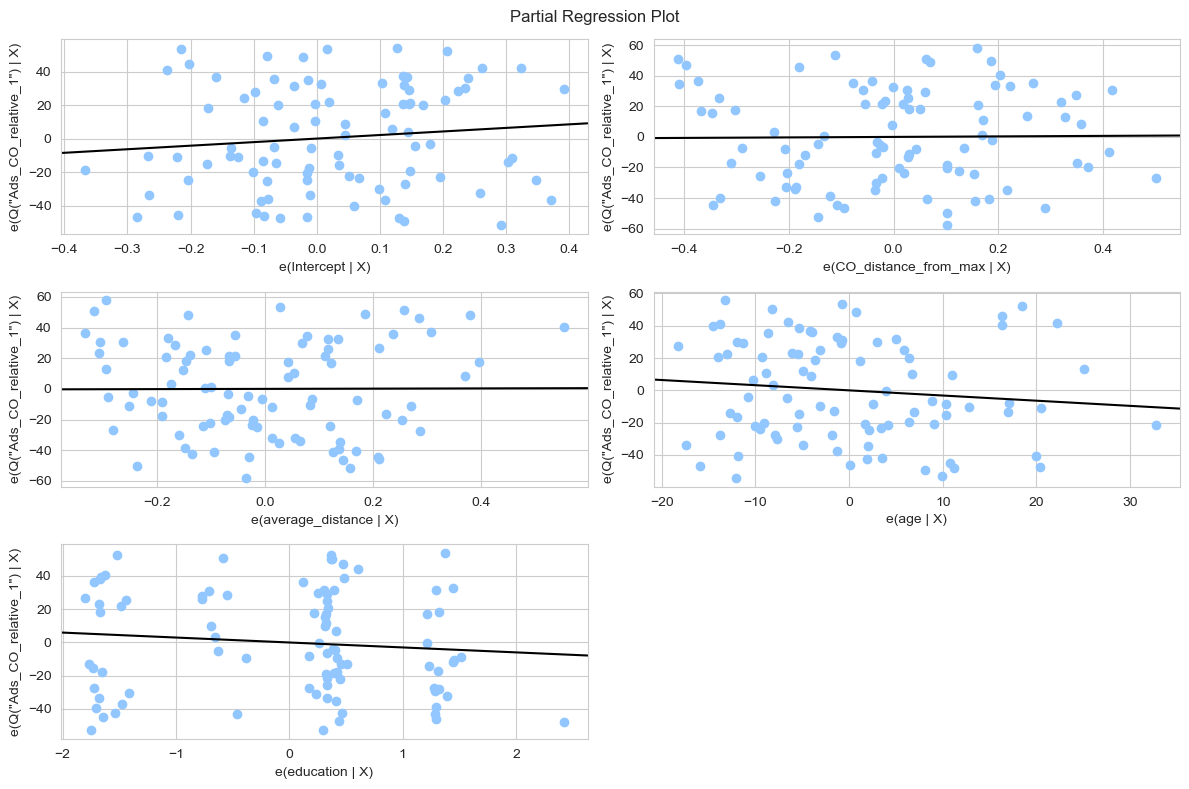

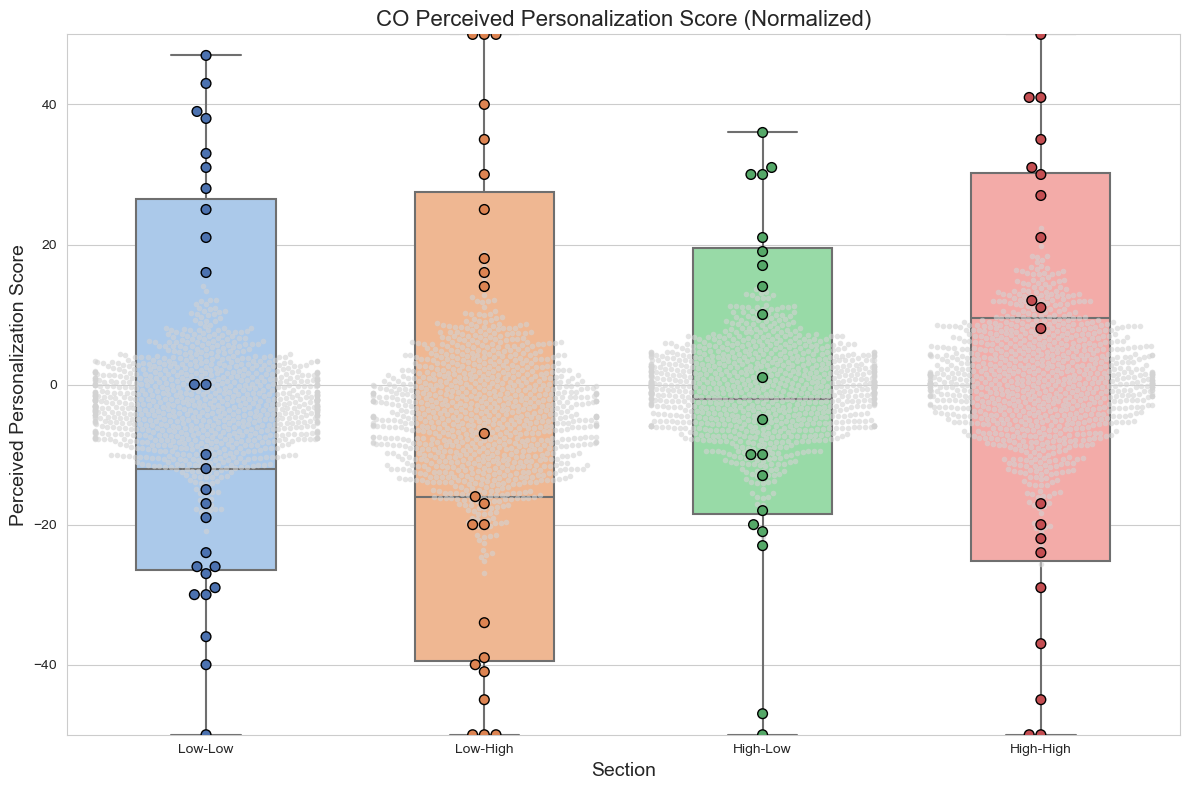


Analysis Results for AG:

Section: High-High
N: 22
Mean: 7.18
95% CI: (-4.05, 17.55)
P-value: 0.2111
Cohen's d: 0.28
Preferred Ad Type: Blended

Section: Low-High
N: 21
Mean: 9.19
95% CI: (-3.48, 21.67)
P-value: 0.1839
Cohen's d: 0.31
Preferred Ad Type: Blended

Section: Low-Low
N: 26
Mean: 8.19
95% CI: (-1.81, 17.77)
P-value: 0.1225
Cohen's d: 0.32
Preferred Ad Type: Blended

Section: High-Low
N: 21
Mean: 12.86
95% CI: (2.62, 22.33)
P-value: 0.0223
Cohen's d: 0.55
Preferred Ad Type: Blended

Linear Regression Results:
                              OLS Regression Results                              
Dep. Variable:     Q("Ads_AG_relative_1")   R-squared:                       0.034
Model:                                OLS   Adj. R-squared:                 -0.012
Method:                     Least Squares   F-statistic:                    0.7454
Date:                    Wed, 21 Aug 2024   Prob (F-statistic):              0.564
Time:                            16:14:51   Log-Likelihood:

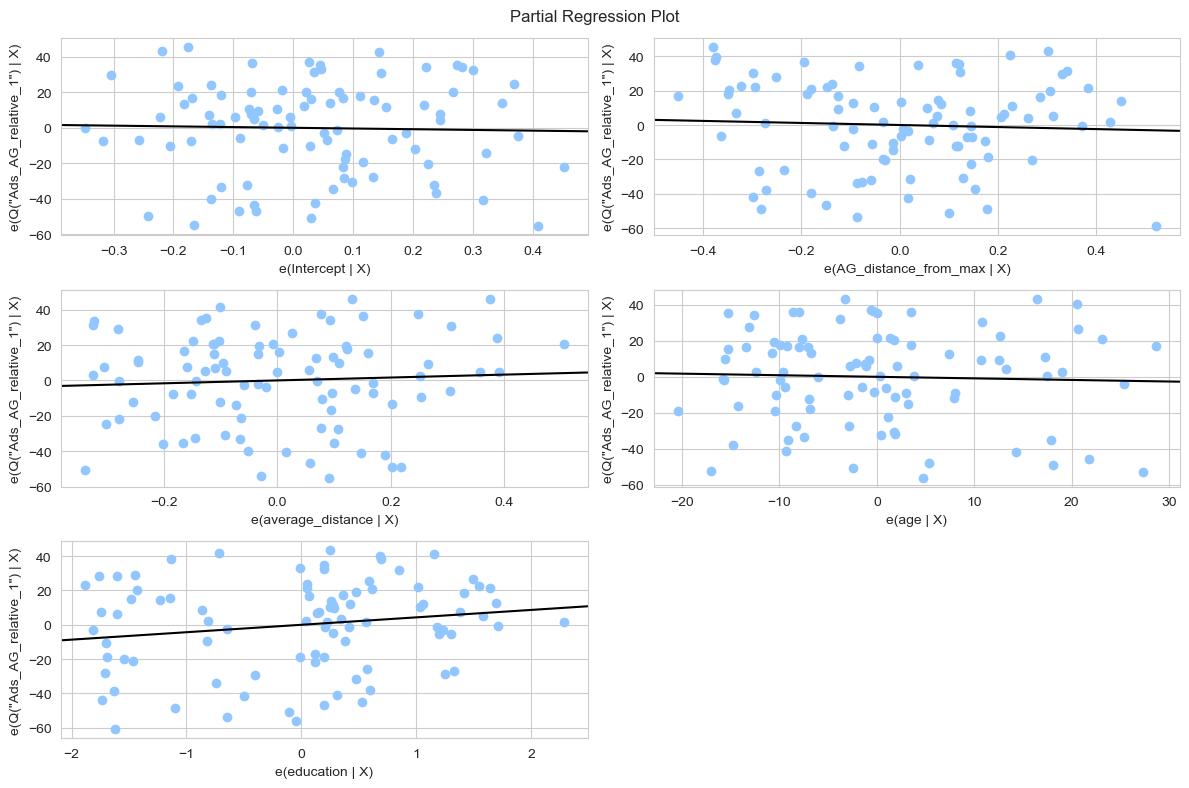

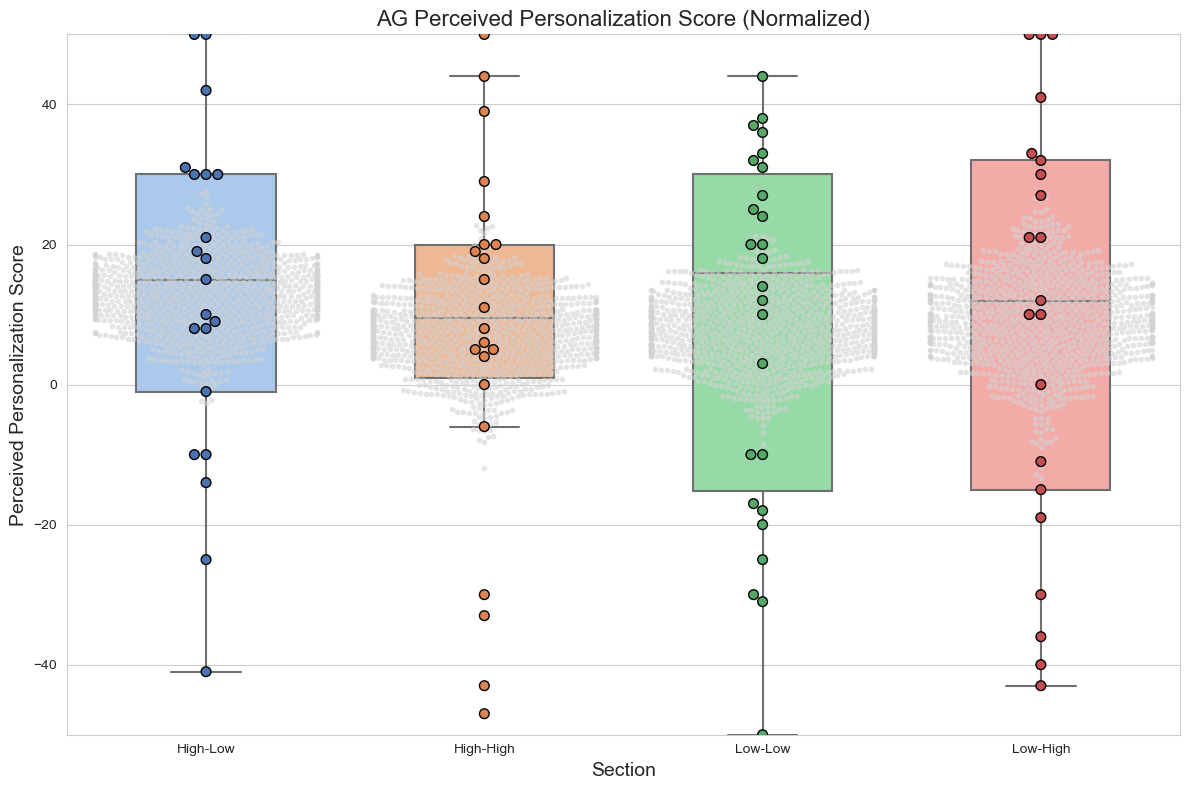

In [94]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import plot_partregress_grid

def analyze_trait_personalization(trait, data, n_bootstrap=10000):
    # データの準備
    analysis_data = data[[f'Ads_{trait}_relative_1', 
                          f'{trait}_distance_from_max', 
                          'average_distance',
                          'age', 'education']].copy()
    
    # セクションの作成
    x_median = analysis_data[f'{trait}_distance_from_max'].median()
    y_median = analysis_data['average_distance'].median()
    
    analysis_data['section'] = np.select(
        [
            (analysis_data[f'{trait}_distance_from_max'] > x_median) & (analysis_data['average_distance'] > y_median),
            (analysis_data[f'{trait}_distance_from_max'] <= x_median) & (analysis_data['average_distance'] > y_median),
            (analysis_data[f'{trait}_distance_from_max'] <= x_median) & (analysis_data['average_distance'] <= y_median),
            (analysis_data[f'{trait}_distance_from_max'] > x_median) & (analysis_data['average_distance'] <= y_median)
        ],
        ['High-High', 'Low-High', 'Low-Low', 'High-Low']
    )
    
    def bootstrap_analysis(scores):
        bootstrap_means = [np.mean(np.random.choice(scores, size=len(scores), replace=True)) for _ in range(n_bootstrap)]
        ci = np.percentile(bootstrap_means, [2.5, 97.5])
        t_stat, p_value = stats.ttest_1samp(scores, 0)
        cohens_d = np.mean(scores) / np.std(scores)
        return np.mean(scores), ci, p_value, cohens_d

    # 各セクションの分析
    results = []
    for section in ['High-High', 'Low-High', 'Low-Low', 'High-Low']:
        section_data = analysis_data[analysis_data['section'] == section][f'Ads_{trait}_relative_1']
        mean, ci, p_value, cohens_d = bootstrap_analysis(section_data)
        results.append({
            'Section': section,
            'N': len(section_data),
            'Mean': mean,
            'CI': ci,
            'P-value': p_value,
            "Cohens d": cohens_d,
            'Preferred': 'Blended' if mean > 0 else 'Single Trait'
        })
    
    # 結果の表示
    print(f"\nAnalysis Results for {trait}:")
    for result in results:
        print(f"\nSection: {result['Section']}")
        print(f"N: {result['N']}")
        print(f"Mean: {result['Mean']:.2f}")
        print(f"95% CI: ({result['CI'][0]:.2f}, {result['CI'][1]:.2f})")
        print(f"P-value: {result['P-value']:.4f}")
        print(f"Cohen's d: {result['Cohens d']:.2f}")
        print(f"Preferred Ad Type: {result['Preferred']}")
    
    # 線形回帰分析
    model = ols(f'Q("Ads_{trait}_relative_1") ~ {trait}_distance_from_max + average_distance + age + education', data=analysis_data).fit()
    print("\nLinear Regression Results:")
    print(model.summary())
    
    # 線形モデルの可視化
    fig = plt.figure(figsize=(12, 8))
    plot_partregress_grid(model, fig=fig)
    plt.tight_layout()
    plt.show()
    
    # スタイリッシュなボックスプロットの作成
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Bootstrap データの生成
    bootstrap_data = []
    for section in analysis_data['section'].unique():
        section_data = analysis_data[analysis_data['section'] == section][f'Ads_{trait}_relative_1']
        for _ in range(1000):  # 1000個のブートストラップサンプル
            bootstrap_sample = np.random.choice(section_data, size=len(section_data), replace=True)
            bootstrap_data.append({'section': section, f'Ads_{trait}_relative_1': np.mean(bootstrap_sample)})
    
    bootstrap_df = pd.DataFrame(bootstrap_data)
    
    # ボックスプロット
    sns.boxplot(x='section', y=f'Ads_{trait}_relative_1', data=analysis_data, 
                palette='pastel', width=0.5, fliersize=0)
    
    # Bootstrap データポイント
    sns.swarmplot(x='section', y=f'Ads_{trait}_relative_1', data=bootstrap_df, 
                  color='lightgray', alpha=0.6, size=4)
    
    # オリジナルデータポイント
    sns.swarmplot(x='section', y=f'Ads_{trait}_relative_1', data=analysis_data, 
                  palette='deep', size=7, edgecolor='black', linewidth=1)
    
    plt.title(f'{trait} Perceived Personalization Score (Normalized)', fontsize=16)
    plt.xlabel('Section', fontsize=14)
    plt.ylabel('Perceived Personalization Score', fontsize=14)
    plt.ylim(-50, 50)  # スコアの範囲を-50から50に設定
    
    # セクションの説明を追加
    #plt.text(0, 52, 'Section 1', ha='center', fontsize=12, color='gray')
    #plt.text(1, 52, 'Section 2', ha='center', fontsize=12, color='gray')
    #plt.text(2, 52, 'Section 3', ha='center', fontsize=12, color='gray')
    #plt.text(3, 52, 'Section 4', ha='center', fontsize=12, color='gray')
    
    plt.tight_layout()
    plt.show()

# 各特性に対して分析を実行
for trait in ['EX', 'OP', 'CO', 'AG']:
    analyze_trait_personalization(trait, merged_df_norm)

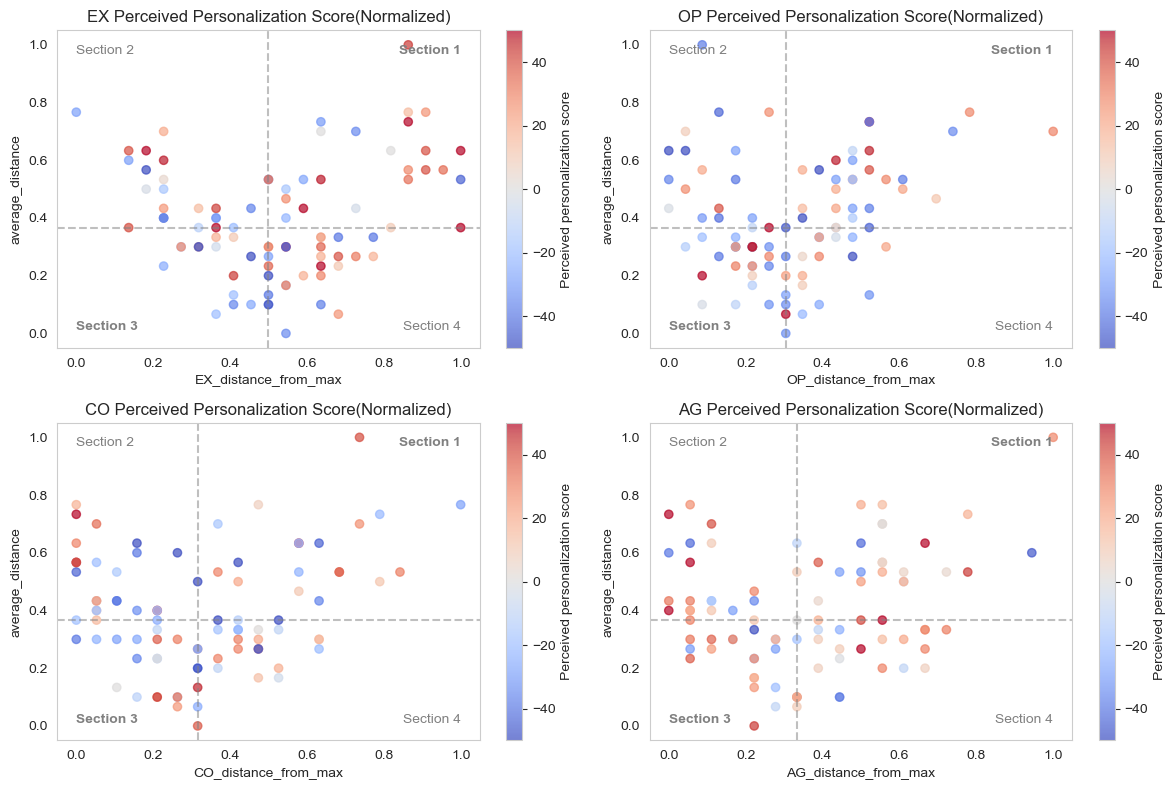

 Section                                                      Desc Trait  N   Mean   Preference              CI  t-statistics  p-value  Cohen's d
       1 High single trait distance, High blended average distance    AG 26   8.19      Blended  (-2.43, 16.53)          1.60   0.1225       0.32
       1 High single trait distance, High blended average distance    CO 27  -2.59 Single Trait  (-11.02, 6.04)         -0.45   0.6530      -0.09
       1 High single trait distance, High blended average distance    EX 26  -7.00 Single Trait  (-18.87, 2.68)         -1.10   0.2826      -0.22
       1 High single trait distance, High blended average distance    OP 32  -5.12 Single Trait  (-17.05, 7.32)         -0.87   0.3921      -0.16
       2  Low single trait distance, High blended average distance    AG 21  12.86      Blended   (2.04, 21.59)          2.48   0.0223       0.55
       2  Low single trait distance, High blended average distance    CO 20  -0.40 Single Trait (-11.98, 10.91)         -0.0

In [99]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

def analyze_trait_bootstrap(traits, data, scaled="", n_bootstrap=10000):
    all_results = []
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    for idx, trait in enumerate(traits):
        x = data[f'{trait}_distance_from_max']
        y = data['average_distance']
        z = data[f'Ads_{trait}_relative_1']
        x_median = np.median(x)
        y_median = np.median(y)

        # 散布図
        scatter = axs[idx].scatter(x, y, c=z, cmap='coolwarm', alpha=0.7)
        axs[idx].grid(False)
        
        # セクション分割線の追加
        axs[idx].axvline(x_median, color='grey', linestyle='--', alpha=0.5)
        axs[idx].axhline(y_median, color='grey', linestyle='--', alpha=0.5)
        axs[idx].set_xlabel(f'{trait}_distance_from_max')
        axs[idx].set_ylabel('average_distance')
        axs[idx].set_title(f'{trait} Perceived Personalization Score{scaled}')
        plt.colorbar(scatter, ax=axs[idx], label='Perceived personalization score')

        # セクションの注釈を追加
        axs[idx].text(x.min(), y.max(), 'Section 2', ha='left', va='top', color='grey')
        axs[idx].text(x.max(), y.max(), 'Section 1', ha='right', va='top', color='grey', weight='bold')
        axs[idx].text(x.min(), y.min(), 'Section 3', ha='left', va='bottom', color='grey', weight='bold')
        axs[idx].text(x.max(), y.min(), 'Section 4', ha='right', va='bottom', color='grey')

        # セクションの定義と分析
        data['section'] = 2 * (y > y_median) + (x > x_median) + 1

        def bootstrap_analysis(scores):
            bootstrap_means = [np.mean(resample(scores, n_samples=len(scores))) for _ in range(n_bootstrap)]
            mean = np.mean(scores)
            ci = np.round(np.percentile(bootstrap_means, [2.5, 97.5]), 2)
            t_stat, p_value = stats.ttest_1samp(scores, 0)
            cohens_d = mean / np.std(scores)
            return mean, ci, t_stat, p_value, cohens_d

        for section in [1, 2, 3, 4]:
            section_data = data[data['section'] == section][f'Ads_{trait}_relative_1']
            mean, ci, t_stat, p_value, cohens_d = bootstrap_analysis(section_data)
            all_results.append({
                'Section': section,
                'Desc': {
                    1: 'High single trait distance, High blended average distance',
                    2: 'Low single trait distance, High blended average distance',
                    3: 'Low single trait distance, Low blended average distance',
                    4: 'High single trait distance, Low blended average distance'
                }[section],
                'Trait': trait,
                'N': len(section_data),
                'Mean': mean,
                'Preference': 'Blended' if mean > 0 else 'Single Trait',
                'CI': f"({ci[0]:.2f}, {ci[1]:.2f})",
                't-statistics': t_stat,
                'p-value': p_value,
                "Cohen's d": cohens_d
            })

    plt.tight_layout()
    plt.show()

    # 結果テーブルの作成と表示
    results_df = pd.DataFrame(all_results)
    results_df = results_df[['Section', 'Desc', 'Trait', 'N', 'Mean', 'Preference', 'CI', 't-statistics', 'p-value', "Cohen's d"]]
    results_df = results_df.sort_values(['Section', 'Trait'])
    results_df = results_df.round({'Mean': 2, 't-statistics': 2, 'p-value': 4, "Cohen's d": 2})
    print(results_df.to_string(index=False))

# 分析の実行
traits = ['EX', 'OP', 'CO', 'AG']
analyze_trait_bootstrap(traits, 
                        merged_df_norm, 
                        scaled="(Normalized)",
                        n_bootstrap=100)

Section Preference Analysis:
 Section Trait  N  Preference Rate  Binomial Test p-value
       1    AG 26           0.6538                 0.1686
       1    CO 27           0.3704                 0.2478
       1    EX 26           0.3846                 0.3269
       1    OP 32           0.3750                 0.2153
       2    AG 21           0.7143                 0.0784
       2    CO 20           0.5000                 1.0000
       2    EX 21           0.7143                 0.0784
       2    OP 15           0.4667                 1.0000
       3    AG 21           0.6190                 0.3833
       3    CO 23           0.4348                 0.6776
       3    EX 20           0.4500                 0.8238
       3    OP 16           0.3125                 0.2101
       4    AG 22           0.7273                 0.0525
       4    CO 20           0.5500                 0.8238
       4    EX 23           0.6087                 0.4049
       4    OP 27           0.5185         

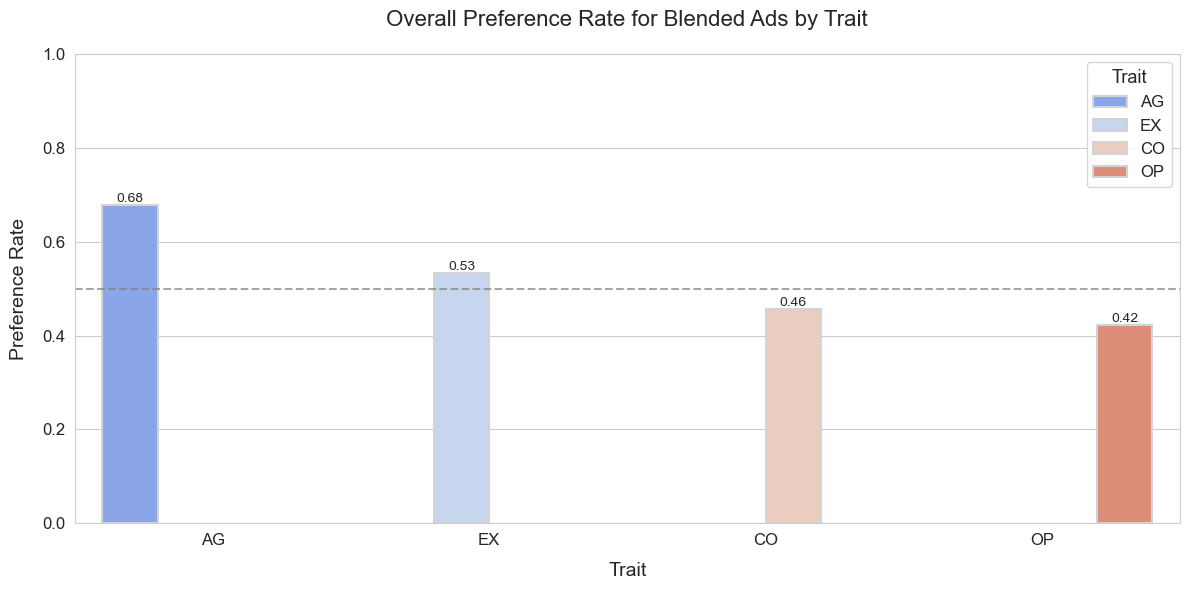

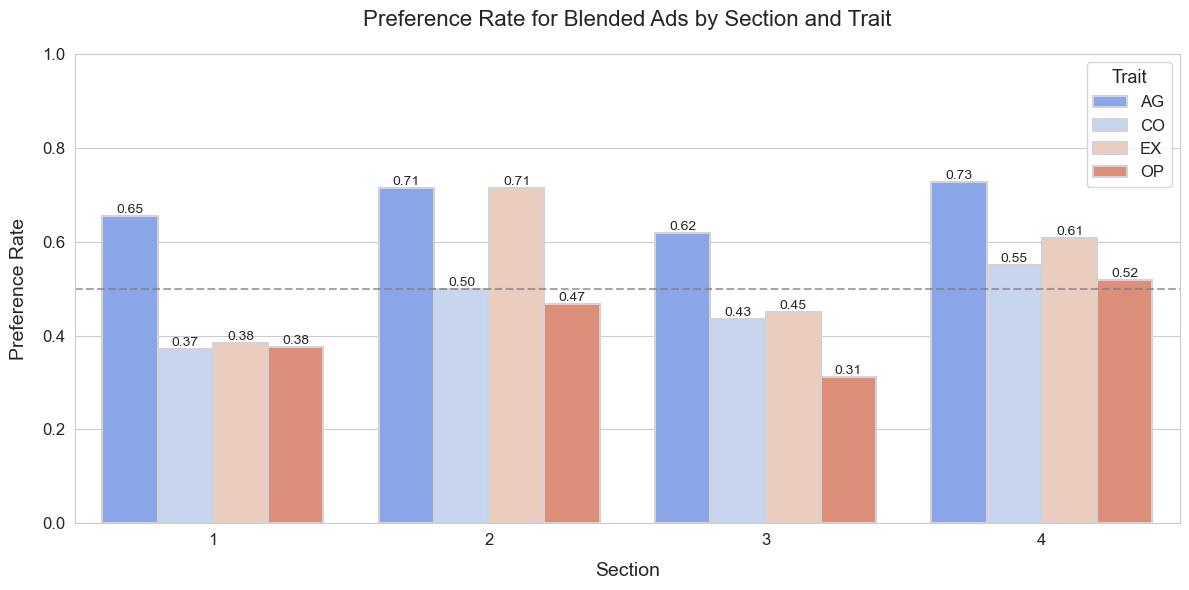

In [96]:
def analyze_trait_bootstrap(traits, data, scaled="", n_bootstrap=10000):
    section_preferences = []
    overall_preference = []

    for trait in traits:
        x = data[f'{trait}_distance_from_max']
        y = data['average_distance']
        z = data[f'Ads_{trait}_relative_1']
        x_median = np.median(x)
        y_median = np.median(y)

        # セクションの定義
        data['section'] = 2 * (y > y_median) + (x > x_median) + 1

        for section in [1, 2, 3, 4]:
            section_data = data[data['section'] == section][f'Ads_{trait}_relative_1']
            preference_rate = np.mean(section_data > 0)
            n_section = len(section_data)
            binom_p_value = stats.binom_test(int(preference_rate * n_section), n_section, p=0.5)
            
            section_preferences.append({
                'Section': section,
                'Trait': trait,
                'N': n_section,
                'Preference Rate': preference_rate,
                'Binomial Test p-value': binom_p_value
            })

        # Calculate overall preference
        trait_data = data[f'Ads_{trait}_relative_1']
        preference_rate = np.mean(trait_data > 0)
        binom_p_value = stats.binom_test(int(preference_rate * len(trait_data)), len(trait_data), p=0.5)
        overall_preference.append({
            'Trait': trait,
            'Preference Rate': preference_rate,
            'Binomial Test p-value': binom_p_value
        })

    # Create dataframes
    section_pref_df = pd.DataFrame(section_preferences)
    section_pref_df = section_pref_df.sort_values(['Section', 'Trait'])
    section_pref_df = section_pref_df.round({'Preference Rate': 4, 'Binomial Test p-value': 4})

    overall_pref_df = pd.DataFrame(overall_preference)
    overall_pref_df = overall_pref_df.sort_values('Preference Rate', ascending=False)
    overall_pref_df = overall_pref_df.round({'Preference Rate': 4, 'Binomial Test p-value': 4})

    # Print results
    print("Section Preference Analysis:")
    print(section_pref_df.to_string(index=False))
    print("\nOverall Preference for Blended Ads:")
    print(overall_pref_df.to_string(index=False))

    # Visualization function
    def plot_preference_rates(data, title, x_label):
        plt.figure(figsize=(12, 6))
        sns.set_style("whitegrid")
        bar_plot = sns.barplot(x=x_label, y='Preference Rate', hue='Trait', data=data, 
                               palette='coolwarm', edgecolor='lightgrey', linewidth=1.5)
        
        plt.title(title, fontsize=16, pad=20)
        plt.xlabel(x_label, fontsize=14, labelpad=10)
        plt.ylabel('Preference Rate', fontsize=14, labelpad=10)
        plt.ylim(0, 1)
        plt.axhline(0.5, color='gray', linestyle='--', alpha=0.7)
        
        for container in bar_plot.containers:
            bar_plot.bar_label(container, fmt='%.2f', label_type='edge')
        
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Trait', title_fontsize='13', fontsize='12')
        plt.gca().set_facecolor('white')
        
        plt.tight_layout()
        plt.show()

    # Visualize overall preference
    plot_preference_rates(overall_pref_df, 'Overall Preference Rate for Blended Ads by Trait', 'Trait')

    # Visualize section preference
    plot_preference_rates(section_pref_df, 'Preference Rate for Blended Ads by Section and Trait', 'Section')

# 分析の実行
traits = ['EX', 'OP', 'CO', 'AG']
analyze_trait_bootstrap(traits, merged_df_norm, scaled="(Normalized)", n_bootstrap=10000)

In [97]:
def analyze_controlled_cdf_robust(data, traits=['EX', 'OP', 'CO', 'AG'], 
                                  n_groups=2, n_bootstrap=1000):
    results = []
    for trait in traits:
        print(f"\n{'-'*50}\nRobust Controlled CDF Analysis for {trait}\n{'-'*50}")
        
        # Create distance groups (coarser segmentation)
        data['trait_distance_group'] = pd.qcut(data[f'{trait}_distance_from_max'], 
                                               q=n_groups, 
                                               labels=['Low', 'High'])
        data['avg_distance_group'] = pd.qcut(data['average_distance'], 
                                             q=n_groups, 
                                             labels=['Low', 'High'])
        
        for trait_group in ['Low', 'High']:
            for avg_group in ['Low', 'High']:
                subset = data[(data['trait_distance_group'] == trait_group) & 
                              (data['avg_distance_group'] == avg_group)]
                
                scores = subset[f'Ads_{trait}_relative_1']
                
                print(f"\nGroup: Trait Distance {trait_group}, Avg Distance {avg_group}")
                print(f"Sample size: {len(subset)}")
                
                if len(scores) > 0:
                    # Bootstrap analysis
                    boot_means = []
                    boot_prefs = []
                    for _ in range(n_bootstrap):
                        boot_scores = resample(scores, n_samples=len(scores))
                        boot_means.append(np.mean(boot_scores))
                        boot_prefs.append(np.sum(boot_scores > 0) / len(boot_scores))
                    
                    # Results
                    mean_score = np.mean(scores)
                    ci_score = np.percentile(boot_means, [2.5, 97.5])
                    blended_pref = np.mean(boot_prefs)
                    blended_pref_ci = np.percentile(boot_prefs, [2.5, 97.5])
                    
                    # T-test
                    t_stat, p_value = stats.ttest_1samp(scores, 0)
                    
                    print(f"Mean score: {mean_score:.4f}")
                    print(f"95% CI: ({ci_score[0]:.4f}, {ci_score[1]:.4f})")
                    print(f"T-statistic: {t_stat:.4f}")
                    print(f"p-value: {p_value:.4f}")
                    print(f"Blended preference: {blended_pref:.2%} (95% CI: {blended_pref_ci[0]:.2%}, {blended_pref_ci[1]:.2%})")
                    
                    results.append({
                        'Trait': trait,
                        'Trait Distance': trait_group,
                        'Avg Distance': avg_group,
                        'N': len(scores),
                        'Mean Score': mean_score,
                        'CI Lower': ci_score[0],
                        'CI Upper': ci_score[1],
                        'T-statistic': t_stat,
                        'P-value': p_value,
                        'Blended Preference': blended_pref,
                        'Blended Pref CI Lower': blended_pref_ci[0],
                        'Blended Pref CI Upper': blended_pref_ci[1]
                    })
                    
                    # Plot histogram
                    plt.figure(figsize=(10, 6))
                    sns.histplot(scores, kde=True)
                    plt.axvline(0, color='r', linestyle='--')
                    plt.xlabel('Perceived Personalization Score')
                    plt.ylabel('Frequency')
                    plt.title(f'Distribution for {trait}: Trait Dist {trait_group}, Avg Dist {avg_group}')
                    plt.show()
                else:
                    print("Not enough data for comparison in this group.")
    
    # Create and display results table
    results_df = pd.DataFrame(results)
    print("\nOverall Results:")
    print(results_df.to_string(index=False))
    
    return results_df

In [98]:
effectiveness_results = analyze_ad_effectiveness_range(merged_df_norm)
print(effectiveness_results)

NameError: name 'analyze_ad_effectiveness_range' is not defined

In [ ]:
analyze_controlled_cdf_robust(merged_df_norm, 
                              traits=['EX', 'OP', 'CO', 'AG'], 
                              n_groups=2, 
                              n_bootstrap=1000)

# sandbox 4

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [ ]:
# ステップ2: 全体的な選好分析
"""
各特性（EX, OP, CO, AG）について、相対的選好スコアの平均値を計算する。
一標本のt検定を使用して、各特性の平均スコアが0と有意に異なるかを検証する。
コメント: この分析により、全体としてBlended広告が好まれているか、
あるいは特定の特性でBlended広告が特に効果的かを把握できます。
"""
def overall_preference_analysis(trait):
    score = data[f'Ads_{trait}_relative_1']
    t_stat, p_value = stats.ttest_1samp(score, 0)
    print(f"{trait} - perceived personalization:")
    print(f"Mean score: {score.mean():.2f}")
    print(f"T-statistic: {t_stat:.2f}, p-value: {p_value:.4f}\n")

for trait in traits:
    overall_preference_analysis(trait)

In [ ]:
# ステップ3: 距離の影響分析
"""
各参加者について、以下の2つの距離を計算する：
a) Blended personaからの距離（既に計算済みのaverage_distance）
b) Single Trait最大スコア（5）からの距離（既に計算済みの{trait}_distance_from_max）
これらの距離と相対的選好スコアの関係を散布図で可視化する。
距離と相対的選好スコアの相関分析を行う。
コメント: この分析により、参加者の特性プロファイルと広告の選好との関係を理解できます。
また、どちらの距離がより強く選好に影響しているかを把握できます。
"""
def distance_analysis(trait):
    # Blended personaからの距離との相関
    corr_blended = stats.pearsonr(data['average_distance'], data[f'Ads_{trait}_relative_1'])
    
    # Single Trait最大スコアからの距離との相関
    corr_single = stats.pearsonr(data[f'{trait}_distance_from_max'], data[f'Ads_{trait}_relative_1'])
    
    print(f"{trait} - perceived personalization:")
    print(f"Correlation with Blended distance: r={corr_blended[0]:.2f}, p={corr_blended[1]:.4f}")
    print(f"Correlation with Single Trait distance: r={corr_single[0]:.2f}, p={corr_single[1]:.4f}\n")
    
    # 散布図
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='average_distance', y=f'Ads_{trait}_relative_1', data=data)
    plt.title(f"{trait} - Perceived Personalization vs Blended Distance")
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=f'{trait}_distance_from_max', y=f'Ads_{trait}_relative_1', data=data)
    plt.title(f"{trait} - Perceived Personalization vs Single Trait Distance")
    plt.tight_layout()
    plt.show()

for trait in traits:
    distance_analysis(trait)

In [ ]:
# ステップ5: セグメント分析
"""
参加者を以下の2つの距離に基づいて分類する：
a) Blended personaからの距離（average_distance）
b) Single Trait最大スコア（5）からの距離
各距離について、参加者を3つのグループ（近い、中間、遠い）に分類する。

各グループ内で、相対的選好スコアの平均を計算し、グループ間で比較する。
Tukey's Honest Significant Difference (HSD) テストを使用することができます。
これは、多重比較の問題を考慮しつつ、すべてのグループペア間の差の有意性を検定する方法です。

二元配置分散分析（Two-way ANOVA）を使用して、Blended距離とSingle Trait距離の両方が
相対的選好スコアに与える影響を分析する。
コメント: この修正により、Blended personaからの距離とSingle Trait最大スコアからの
距離の両方を考慮したセグメント分析が可能になります。
これにより、どのような特性プロファイルを持つ人々にBlended広告が特に効果的か、
あるいはSingleが効果的かをより詳細に理解できます。
"""

def segment_analysis_robust(trait, data, n_segments=3):
    # セグメントのラベルを3つに変更
    segment_labels = ['near', 'middle', 'far']
    
    data['blended_segment'] = pd.qcut(data['average_distance'], q=n_segments, labels=segment_labels)
    data[f'{trait}_single_segment'] = pd.qcut(data[f'{trait}_distance_from_max'], q=n_segments, labels=segment_labels)
    
    # グループごとの平均スコア計算
    grouped_means = data.groupby(['blended_segment', f'{trait}_single_segment'])[f'Ads_{trait}_relative_1'].mean().unstack()
    print(f"{trait} - Perceived Personalization グループ平均:")
    print(grouped_means)
    print()
    
    # 二元配置分散分析
    model = ols(f'Ads_{trait}_relative_1 ~ C(blended_segment) + C({trait}_single_segment) + C(blended_segment):C({trait}_single_segment)', data=data).fit()
    anova_table = anova_lm(model, typ=2)
    print(f"{trait} - Perceived Personalization 二元配置分散分析結果:")
    print(anova_table)
    print()
    
    # Kruskal-Wallis検定（ノンパラメトリック検定）
    kruskal_blended = kruskal(*[group[f'Ads_{trait}_relative_1'].values for name, group in data.groupby('blended_segment')])
    kruskal_single = kruskal(*[group[f'Ads_{trait}_relative_1'].values for name, group in data.groupby(f'{trait}_single_segment')])
    
    print("Kruskal-Wallis test results:")
    print(f"Blended segment: H-statistic = {kruskal_blended.statistic:.4f}, p-value = {kruskal_blended.pvalue:.4f}")
    print(f"Single trait segment: H-statistic = {kruskal_single.statistic:.4f}, p-value = {kruskal_single.pvalue:.4f}")
    print()
    
    # 効果量の計算（Cohen's d）
    def cohens_d(group1, group2):
        n1, n2 = len(group1), len(group2)
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        return (np.mean(group1) - np.mean(group2)) / pooled_se

    blended_groups = [group[f'Ads_{trait}_relative_1'].values for name, group in data.groupby('blended_segment')]
    single_groups = [group[f'Ads_{trait}_relative_1'].values for name, group in data.groupby(f'{trait}_single_segment')]
    
    print("Effect sizes (Cohen's d):")
    print(f"Blended segment (近い vs 遠い): {cohens_d(blended_groups[0], blended_groups[-1]):.4f}")
    print(f"Single trait segment (近い vs 遠い): {cohens_d(single_groups[0], single_groups[-1]):.4f}")
    print()
    
    # データの可視化
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='blended_segment', y=f'Ads_{trait}_relative_1', hue=f'{trait}_single_segment', data=data)
    plt.title(f'{trait} - Perceived Personalization by Segment')
    plt.show()
    
    print("\n" + "="*50 + "\n")

for trait in traits:
    segment_analysis_robust(trait, merged_df_norm)